My friends and family have been incredibly generous and provided their Spotify data for this project <br>
This analysis focuses on finding patterns and similarities in the data

# Libraries

In [3]:
# Data wrangling:
import pandas as pd
import json
import numpy as np
import os
import re

# Plotting:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from IPython.display import Markdown, display
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter

# Functions

In [5]:
def make_venns(name, compare_to = "Emily"):
    # Read in data
    # if it exists
    if "YourLibrary.json" not in os.listdir(name):
        return None
    filename = (name + "/YourLibrary.json")

    with open(filename, "r") as f:
        dat = json.load(f)
    comp_filename = (compare_to + "/YourLibrary.json")
    with open(comp_filename, "r") as f:
        comp_dat = json.load(f)
    
    # songs
    temp = pd.DataFrame(dat["tracks"]) 
    if len(temp) == 0:
        print(name, "has 0 songs saved")
    else:
        comp = pd.DataFrame(comp_dat["tracks"])
        comp_only = len(set(comp["uri"]) - set(temp["uri"]))
        in_common = comp[comp["uri"].isin(temp["uri"])]
        overlap = len(in_common)
        other_only = len(set(temp["uri"]) - set(comp["uri"]))
        venn2(subsets = (comp_only, other_only, overlap), set_labels = (compare_to, name))
        plt.title((compare_to + " and " + name + ", songs in common"))
        plt.show()
        if overlap > 0:
            if overlap > 10:
                display(Markdown("Some songs in common:"))
                print(list(in_common["track"])[0:6])
            else:
                display(Markdown("Songs in common:"))
                print(list(in_common["track"]))
    # little space
    print()
    
    # artists
    temp = find_total_artists(name)
    if len(temp) == 0:
        print(name, "has 0 artists followed or saved")
    else:
        comp_artists = find_total_artists(compare_to)
        comp_only = len(set(comp_artists) - set(temp))
        in_common = pd.Series(list(set(comp_artists).intersection(set(temp))))
        overlap = len(in_common)
        other_only = len(set(temp) - set(comp_artists))
        venn2(subsets = (comp_only, other_only, overlap), set_labels = (compare_to, name))
        plt.title((compare_to + " and " + name + ", artists in common"))
        plt.show()
        if(overlap > 0):
            if overlap > 10:
                display(Markdown("Some artists in common:"))
                print(list(in_common)[0:6])
            else:
                display(Markdown("Artists in common:"))
                print(list(in_common))
    print()
        
    # albums
    temp = pd.DataFrame(dat["albums"]) 
    if len(temp) == 0:
        print(name, "has 0 albums saved")
    else:
        comp = pd.DataFrame(comp_dat["albums"])
        comp_only = len(set(comp["uri"]) - set(temp["uri"]))
        # overlap = sum(my_albums["uri"].isin(temp["uri"]))
        in_common = comp[comp["uri"].isin(temp["uri"])]
        overlap = len(in_common)
        other_only = len(set(temp["uri"]) - set(comp["uri"]))
        venn2(subsets = (comp_only, other_only, overlap), set_labels = (compare_to, name))
        plt.title((compare_to + " and " + name + ", albums in common"))
        plt.show()
        if(overlap > 0):
            if overlap > 10:
                display(Markdown("Albums in common:"))
                print(list(in_common["album"])[0:6])
            else:
                display(Markdown("Albums in common:"))
                print(list(in_common["album"]))
    print()


In [6]:
def banned_flag(name):
    if "YourLibrary.json" not in os.listdir(name):
        return None
    filename = (name + "/YourLibrary.json")
    with open(filename, "r") as f:
        dat = json.load(f)
    if len(dat["bannedTracks"]) != 0:
        text = ("<span style='color:red'>**"+name+" has blocked these songs:**</span>")
        display(Markdown(text))
        display(pd.DataFrame(dat["bannedTracks"]))
    if len(dat["bannedArtists"]) != 0:
        text = "<span style='color:red'>**"+name+" has blocked these artists:**</span>"
        display(Markdown(text))
        display(pd.DataFrame(dat["bannedArtists"]))

In [7]:
def find_top_genres(name):
    if "Wrapped2024.json" not in os.listdir(name):
        return pd.Series()
    filename = (name + "/Wrapped2024.json")
    with open(filename, "r") as f:
        dat = json.load(f)
    genres = pd.Series()
    if "musicEvolution" in list(dat.keys()):
        genres = pd.DataFrame(dat["musicEvolution"]["eras"])["genre"]
    return genres

def find_top_moods(name):
    if "Wrapped2024.json" not in os.listdir(name):
        return pd.Series()
    filename = (name + "/Wrapped2024.json")
    with open(filename, "r") as f:
        dat = json.load(f)
    moods = pd.Series()
    if "musicEvolution" in list(dat.keys()):
        moods = pd.DataFrame(dat["musicEvolution"]["eras"])["mood"]
    return moods

def find_top_descriptors(name):
    if "Wrapped2024.json" not in os.listdir(name):
        return pd.Series()
    filename = (name + "/Wrapped2024.json")
    with open(filename, "r") as f:
        dat = json.load(f)
    descriptors = pd.Series()
    if "musicEvolution" in list(dat.keys()):
        descriptors = pd.DataFrame(dat["musicEvolution"]["eras"])["descriptor"]
    return descriptors

In [8]:
def find_total_artists(name):
    if "YourLibrary.json" not in os.listdir(name):
        return None
    filename = (name + "/YourLibrary.json")
    with open(filename, "r") as f:
        dat = json.load(f)
    tot_artists = []
    if len(pd.DataFrame(dat["tracks"])) > 0:
        tot_artists.extend(list(pd.DataFrame(dat["tracks"])["artist"]))
    if len(pd.DataFrame(dat["artists"])) > 0:
        tot_artists.extend(list(pd.DataFrame(dat["artists"])["name"]))
    if len(list(pd.DataFrame(dat["albums"]))) > 0:
       tot_artists.extend(list(pd.DataFrame(dat["albums"])["artist"])) 
    tot_artists = pd.Series(tot_artists)
    tot_artists.drop_duplicates(inplace=True)
    tot_artists = tot_artists[tot_artists != "Various Artists"]
    return tot_artists

In [9]:
def music_hours(name):
    pattern = re.compile(r'^StreamingHistory_music_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    # print(stream_files)
    hours = list()
    for i in range(len(stream_files)):
        temp = pd.read_json(name + "/" + stream_files[i])
        hours.append(np.sum(temp["msPlayed"]/1000/60/60))
    # print(hours)
    return(round(np.sum(hours), 2))

In [10]:
def stream_history(name):
    pattern = re.compile(r'^StreamingHistory_music_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    stream_hist = pd.DataFrame(columns = (['endTime', 'artistName', 'trackName', 'msPlayed']))
    for i in range(len(stream_files)):
        temp = pd.read_json(name + "/" + stream_files[i])
        stream_hist = pd.concat([stream_hist, temp], ignore_index=True)
    # print(hours)
    return stream_hist

In [11]:
def past_year_artists(name):
    pattern = re.compile(r'^StreamingHistory_music_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    artists = list()
    for i in range(len(stream_files)):
        temp = pd.read_json(name + "/" + stream_files[i])
        artists = (artists + list(temp["artistName"].unique()))
    artists = list(set(artists))
    return artists

In [12]:
def past_year_songs(name):
    pattern = re.compile(r'^StreamingHistory_music_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    songs = list()
    for i in range(len(stream_files)):
        temp = pd.read_json(name + "/" + stream_files[i])
        songs = (songs + list(temp["trackName"].unique()))
    songs = list(set(songs))
    return songs

In [13]:
def audiobook_hours(name):
    pattern = re.compile(r'^StreamingHistory_audiobook_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    # print(stream_files)
    if stream_files==None:
        return 0
    else:
        hours = list()
        for i in range(len(stream_files)):
            temp = pd.read_json(name + "/" + stream_files[i])
            hours.append(np.sum(temp["msPlayed"]/1000/60/60))
        # print(hours)
        return(round(np.sum(hours), 2))

In [14]:
def pod_hours(name):
    pattern = re.compile(r'^StreamingHistory_podcast_\d+\.json$')
    stream_files = [
        filename for filename in os.listdir(name)
        if pattern.match(filename)]
    # print(stream_files)
    if stream_files==None:
        return 0
    else:
        hours = list()
        for i in range(len(stream_files)):
            temp = pd.read_json(name + "/" + stream_files[i])
            hours.append(np.sum(temp["msPlayed"]/1000/60/60))
        # print(hours)
        return(round(np.sum(hours), 2))

In [15]:
volunteers = (["Sidney", "Kelsey", "Ashley", "Robin", "Dan", "Jenn", "Alex", "Matt", "Krissy", "Hali", "Celina", "Amanda", "Diane", "Margaret"])
everyone = volunteers.copy()
everyone.append("Emily")

# Library analysis

In [17]:
# Starting by opening my own data to see how it's formatted
with open("Emily/YourLibrary.json", "r") as f:
    data = json.load(f)
# display(data)
if isinstance(data, dict):
    print("Top-level keys:", data.keys())
my_tracks = pd.DataFrame(data["tracks"])
print("tracks:")
display(my_tracks.head())
my_artists = pd.DataFrame(data["artists"])
print("artists:")
display(my_artists.head())
my_albums = pd.DataFrame(data["albums"])
print("albums:")
display(my_albums.head())

# display(data["bannedTracks"])
# display(data["bannedArtists"])
# pd.DataFrame(data["other"])
banned_flag("Emily")

Top-level keys: dict_keys(['tracks', 'albums', 'shows', 'episodes', 'bannedTracks', 'artists', 'bannedArtists', 'other'])
tracks:


,artist,album,track,uri
0,Lorde,Melodrama,Supercut,spotify:track:6K8VQ84MqhsoakN5MjrnVR
1,Ingrid Andress,Lady Like,Lady Like,spotify:track:33UI8dgfkDOf32DWBH1GL0
2,Old Dominion,Meat and Candy,Break Up with Him,spotify:track:5ZManJDV3CexO66nRCkdiV
3,Beyoncé,COWBOY CARTER,PROTECTOR,spotify:track:4dsdSwSdBWjlsVzU6iJs3b
4,Angaleena Presley,Wrangled,High School,spotify:track:7BscuqIxCqCNMwgEXCyuzC


artists:


,name,uri
0,AOBeats,spotify:artist:2tfyKNBwTB41ArvliXX1zA
1,Alice Merton,spotify:artist:7f0OLhGgBMX9fUjm1dcPip
2,Amrit Kaur,spotify:artist:7G4R492mjIIVQbQPH2q6JS
3,Amythyst Kiah,spotify:artist:1lhaaKpTyXOnjp79M3xYBl
4,Angaleena Presley,spotify:artist:7hmwyQifkGl8GgOMVJZvW0


albums:


,artist,album,uri
0,Tegan and Sara,So Jealous,spotify:album:2yNhqBKfZPzrxRJqGMbSz9
1,Lana Del Rey,Ultraviolence,spotify:album:1ORxRsK3MrSLvh7VQTF01F
2,Sara Evans,Words,spotify:album:4IzQueTW4TG1V6hxEAtvcr
3,Miranda Lambert,Crazy Ex-Girlfriend,spotify:album:4y5aIMkIOdo6z1c8qsI6xb
4,Miranda Lambert,The Weight of These Wings,spotify:album:563h536tB6n8Dn62jr4RZG


In [18]:
# Diane sent me her total streaming history so I'm parsing her data a little differently
# Then writing a new json so it does match the format of everyone else's

diane_data = pd.read_json("Diane/Streaming_History_Audio_2020-2025.json")

# diane_data[diane_data["ts"] > 2024]
diane_data["ts"][0].split("-", 1)[0]
# new_colnames.append(list(df.columns.astype(str))[i].split(" ", 1)[0])

yrs = list()
for i in range(len(diane_data)):
    yrs.append(diane_data["ts"][i].split("-", 1)[0])

# yrs[0:6]
diane_data["year"] = yrs
diane_data[diane_data["year"] == "2024"].head()
diane_data.columns

diane2024 = diane_data[diane_data["year"] == "2024"]

# print(diane2024.columns)
# diane2024.head()
diane2024 = diane2024.drop(["platform", "conn_country", "ip_addr", "episode_name", "audiobook_chapter_uri", 
                            "audiobook_chapter_title", "reason_start", "reason_end", "shuffle", "skipped", "offline", 
                            "incognito_mode", "episode_show_name", "spotify_episode_uri", "audiobook_uri"], axis = 1)
diane2024 = diane2024.iloc[:,0:4]
diane2024.reset_index(inplace=True, drop = True)  
diane2024.columns = (("endTime", "msPlayed", "trackName", "artistName"))
diane2024.head()

# commenting out because I only needed to run once
# diane2024.to_json("Diane/StreamingHistory_music_0.json") 

,endTime,msPlayed,trackName,artistName
0,2024-01-11T20:05:03Z,116909,Nightlife,Morning Silk
1,2024-01-11T20:10:36Z,240268,Habits,Cal in Red
2,2024-01-11T20:14:25Z,228590,Don't Try Hard Enough,Morning Silk
3,2024-01-11T20:18:30Z,182580,Tommy,Richie Quake
4,2024-01-11T20:21:19Z,168533,Under the Gun,Morning Silk


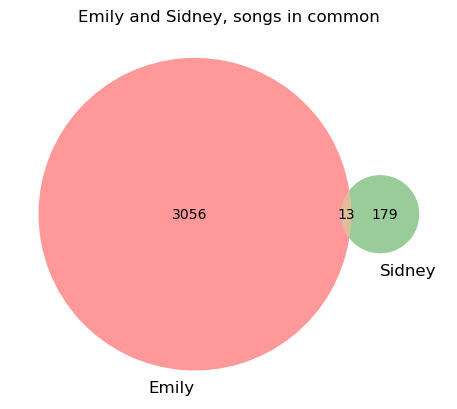

Some songs in common:

['Pon de Replay', 'Just Dance', 'Heartless', 'Single Ladies (Put a Ring on It)', 'Poker Face', 'Battlefield']



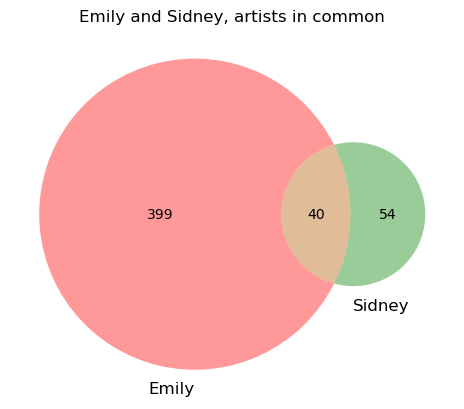

Some artists in common:

['The Veronicas', 'Black Eyed Peas', 'Kesha', 'Young Money', 'Gym Class Heroes', 'Jay Sean']



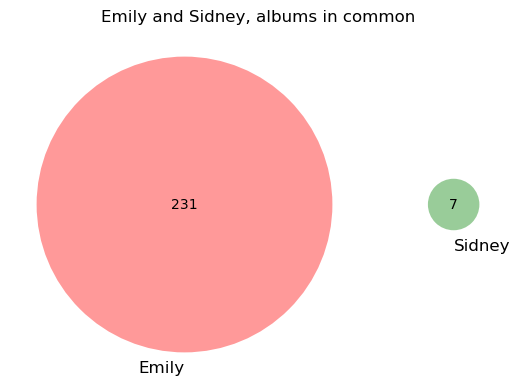

<span style='color:red'>**Kelsey has blocked these artists:**</span>

,name,uri
0,Travis Scott,spotify:artist:0Y5tJX1MQlPlqiwlOH1tJY


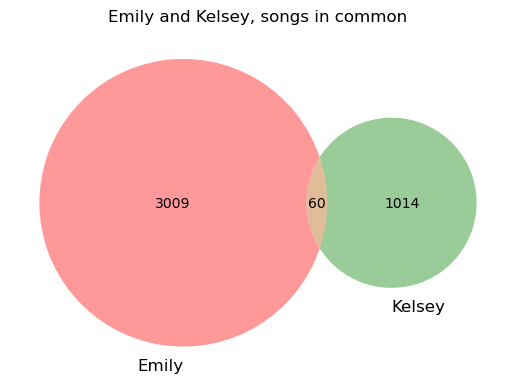

Some songs in common:

['Getaway Car', 'Levels', 'Drops of Jupiter (Tell Me)', 'Lover', 'No Roots', "This Is Why We Can't Have Nice Things"]



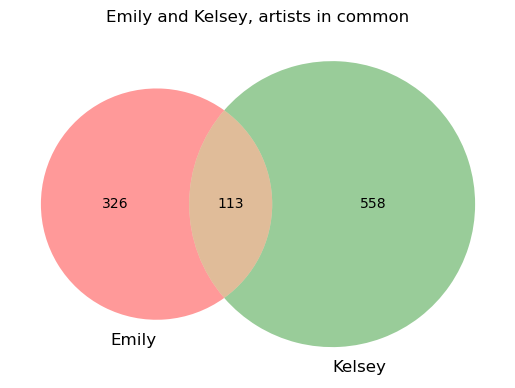

Some artists in common:

['Black Eyed Peas', '*NSYNC', 'Chappell Roan', 'Train', 'New Radicals', 'Alice Merton']



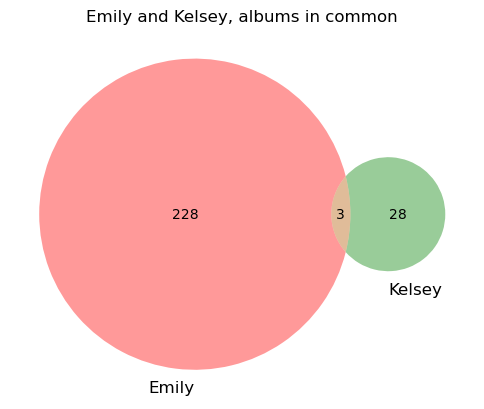

Albums in common:

['reputation', 'Hamilton', 'Midnights']



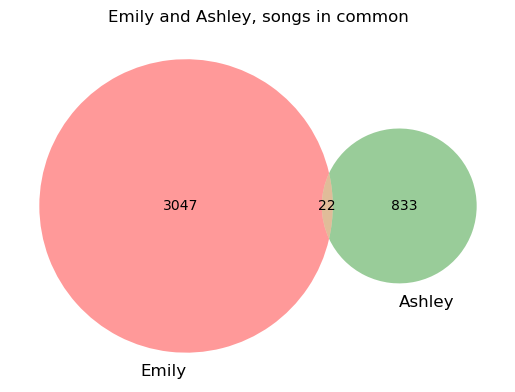

Some songs in common:

['Good as Hell', 'High Horse', 'Deep', 'Rainbow', 'Burning', 'Butterflies']



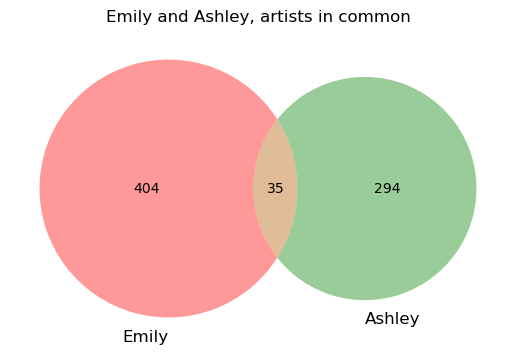

Some artists in common:

['Kesha', '*NSYNC', 'Reneé Rapp', 'Tacocat', 'Christina Aguilera', 'girl in red']



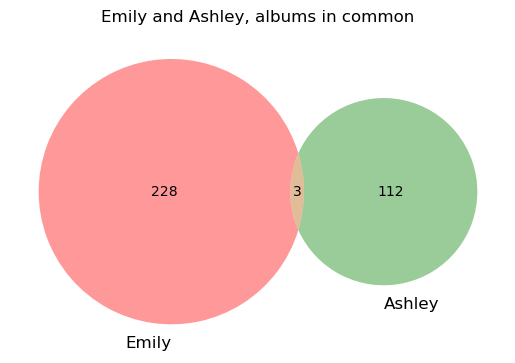

Albums in common:

['Coconut Oil', 'Golden Hour', 'MONTERO']



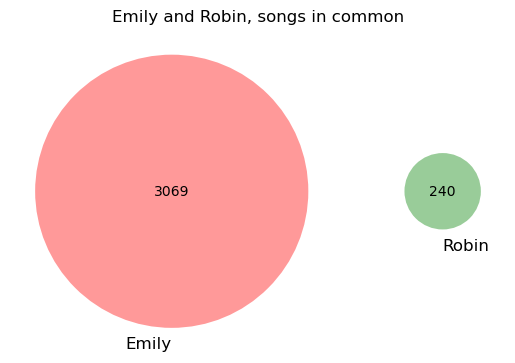

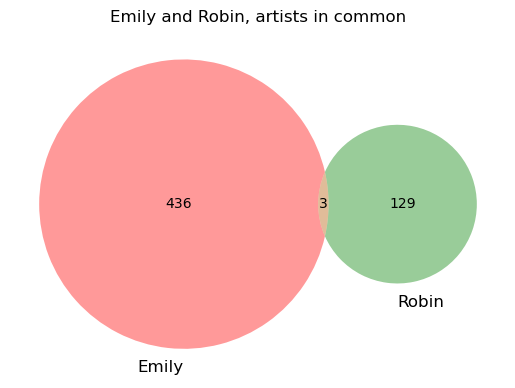

Artists in common:

['Rhiannon Giddens', 'Kasey Chambers', 'Florence + The Machine']



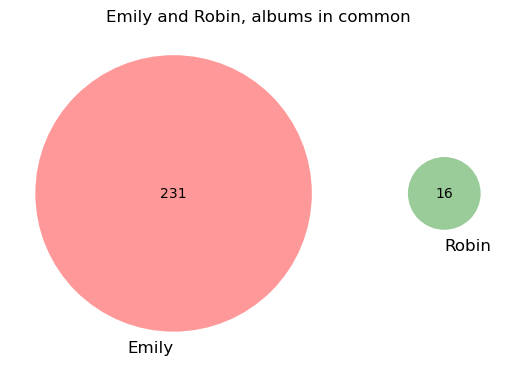

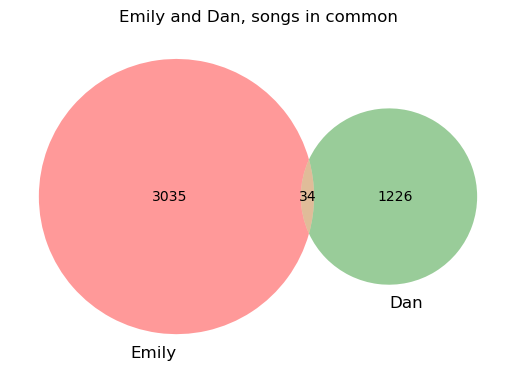

Some songs in common:

['Bravado', 'Tell Me Why (Taylor’s Version)', 'LoveGame', 'Beautiful, Dirty, Rich', 'Finesse - Remix; feat. Cardi B', 'Just Dance']



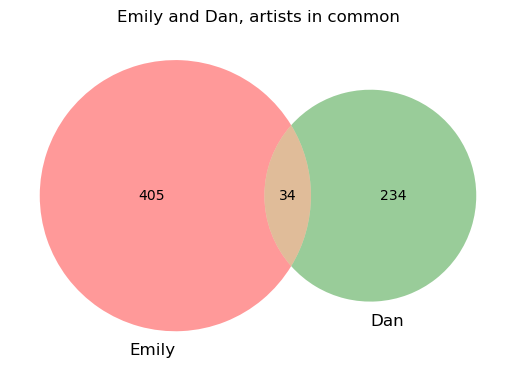

Some artists in common:

['Sabrina Carpenter', 'Avicii', 'Beyoncé', 'Lido Pimienta', 'Yola', 'Christina Aguilera']



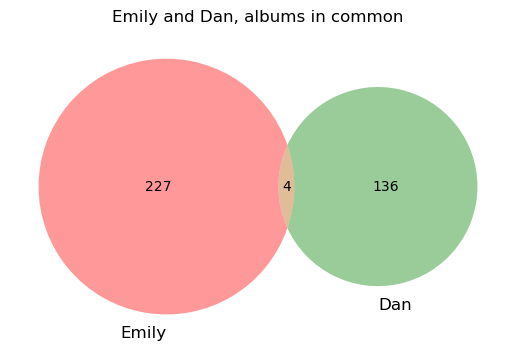

Albums in common:

['Red', 'BRAT', 'Golden Hour', "Short n' Sweet"]



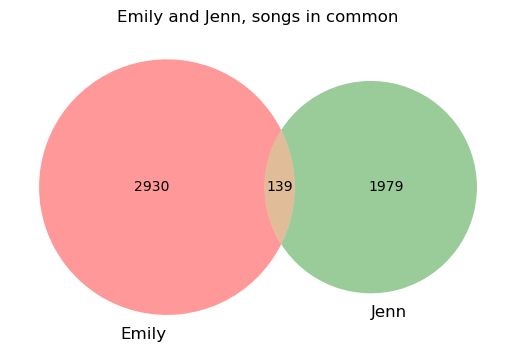

Some songs in common:

['Old Town Road (feat. Billy Ray Cyrus) - Remix', 'You Never Knew', 'Getaway Car', "We Won't", 'Lady Marmalade - From "Moulin Rouge" Soundtrack', 'Thirties']



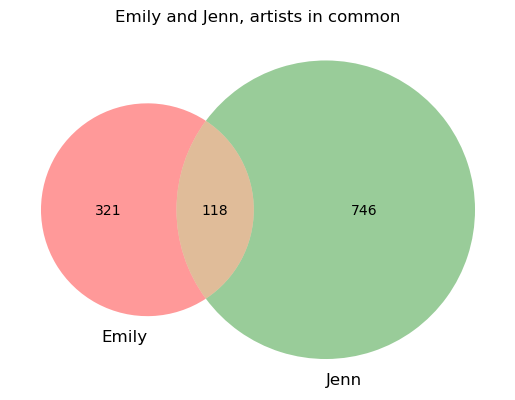

Some artists in common:

['Avicii', 'Chappell Roan', 'Train', 'Alice Merton', 'Hilary Duff', 'HAIM']



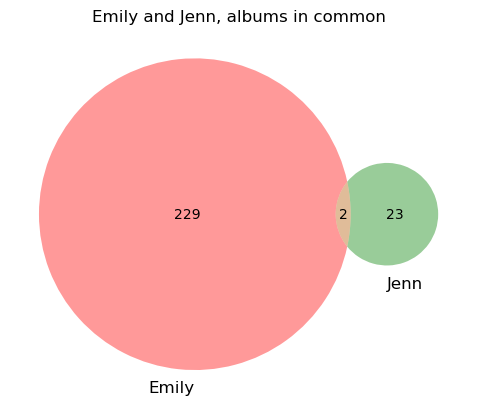

Albums in common:

['Hamilton', 'Queen Of The Clouds']



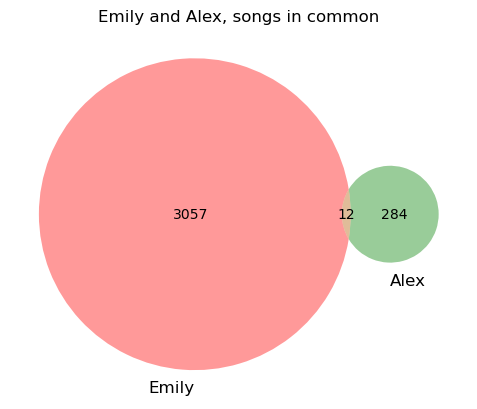

Some songs in common:

['Supercut', 'Rain On Me (with Ariana Grande)', 'PILLOWTALK', 'High Horse', 'a thousand years', 'Me & U']



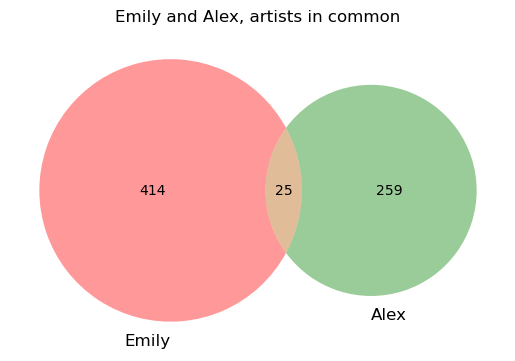

Some artists in common:

['Cassie', 'The Veronicas', 'Cardi B', 'Zach Bryan', 'The Weeknd', 'Shania Twain']



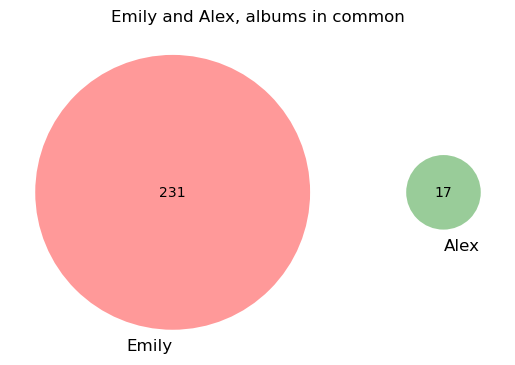

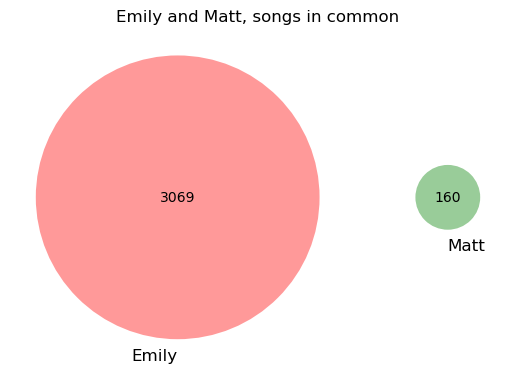

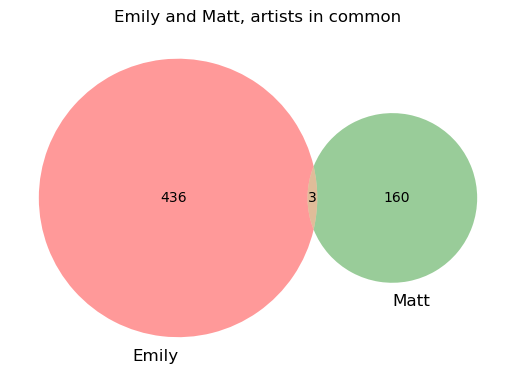

Artists in common:

['Passion Pit', 'Chappell Roan', 'Daft Punk']



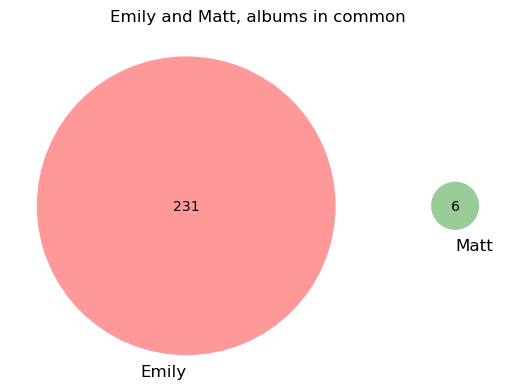

<span style='color:red'>**Krissy has blocked these songs:**</span>

,artist,album,track,uri
0,Sophia Wackerman,Stop Your Lying,Stop Your Lying,spotify:track:34R0pfXfMODRhKsHQUWCLO


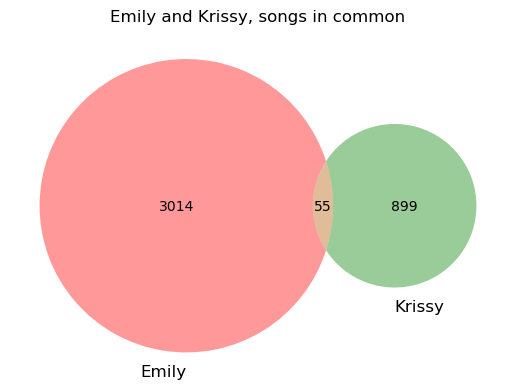

Some songs in common:

['Everything Has Changed (feat. Ed Sheeran) (Taylor’s Version)', "Wildest Dreams (Taylor's Version)", 'willow', 'Lady Marmalade - From "Moulin Rouge" Soundtrack', 'Put Your Records On', 'Drops of Jupiter (Tell Me)']



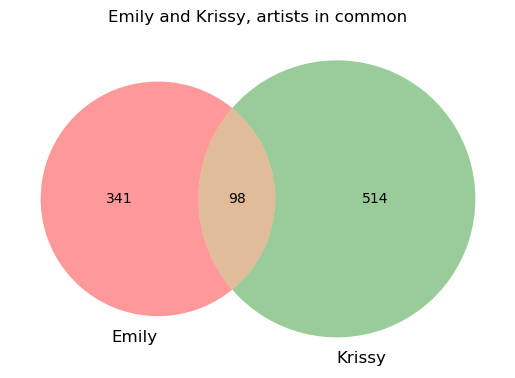

Some artists in common:

['Avicii', '*NSYNC', 'Chappell Roan', 'Train', 'Darius Rucker', 'Dave Matthews Band']



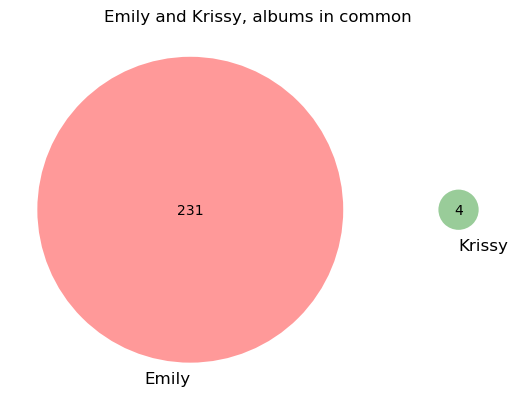


Hali has 0 songs saved

Hali has 0 artists followed or saved

Hali has 0 albums saved



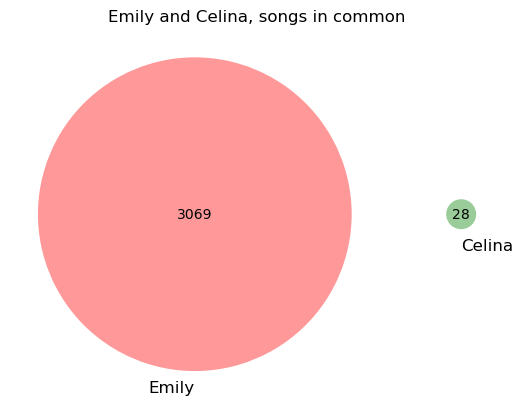

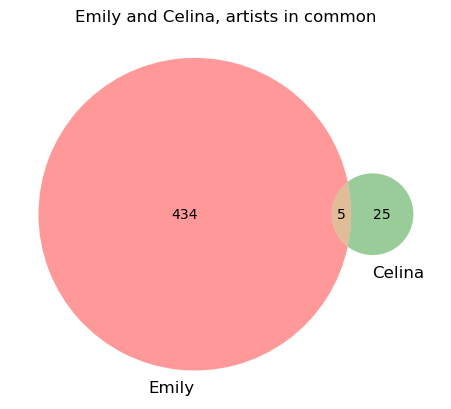

Artists in common:

['Bruno Mars', 'Black Eyed Peas', 'Billie Eilish', 'Dua Lipa', 'Beyoncé']

Celina has 0 albums saved



<span style='color:red'>**Amanda has blocked these songs:**</span>

,artist,album,track,uri
0,Organized Noize,Organized Noize,Anybody out There,spotify:track:0UKFHRE9lzF7zBh9G8hFfs
1,Kanye West,The Life Of Pablo,Real Friends,spotify:track:66Q3fAmSX5eHamgbKa9alP
2,Johanna Warren,nūmūn,Follow,spotify:track:2HuWIcmAkRIV9x9lUPsq6O
3,Taylor Swift,Red,We Are Never Ever Getting Back Together,spotify:track:7AEAGTc8cReDqcbPoY9gwo
4,All Time Low,Nothing Personal (Deluxe Version),Damned If I Do Ya (Damned If I Don't),spotify:track:7LcNhnWCI9w9ivknoSqtvK
5,LMNT,Juliet,Juliet - Single Edit,spotify:track:4cIedAXi7s8BYl4eRjC3Bc
6,Lorde,The Hunger Games: Catching Fire,Everybody Wants To Rule The World - From “The ...,spotify:track:4O5RiBr3MXQojn3qNoMpOD
7,Kanye West,The Life Of Pablo,Facts (Charlie Heat Version),spotify:track:3MnbXlC1N7GdS9M8HzA6no
8,Jessie J,Pitch Perfect 2 - Special Edition,"Flashlight - From ""Pitch Perfect 2"" Soundtrack",spotify:track:6SkoBaMd0lzoQjID5aV2d9
9,Imagine Dragons,Smoke + Mirrors,Who We Are,spotify:track:236DIFE6J4lbdknreVZSN6


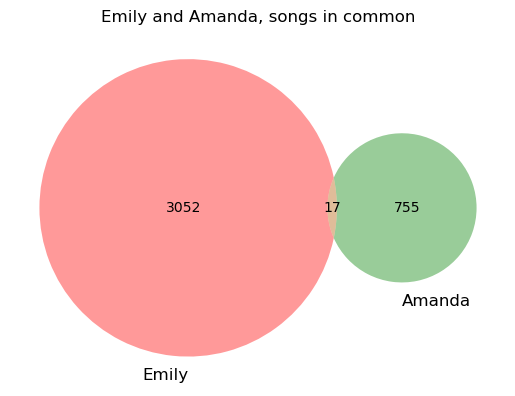

Some songs in common:

['Dancing On My Own - Radio Edit', 'Good as Hell', 'Cups - Movie Version', 'Highwomen', 'I Like It', 'Deep']



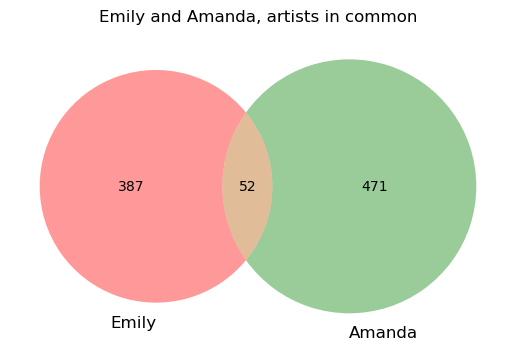

Some artists in common:

['The Veronicas', 'Nanci Griffith', 'Chappell Roan', 'Cardi B', 'Jason Isbell and the 400 Unit', 'Tacocat']



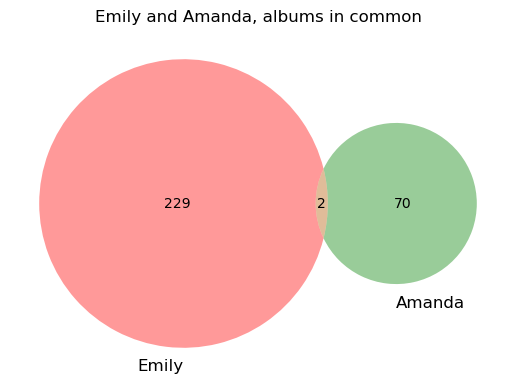

Albums in common:

['Hamilton', 'Coconut Oil']



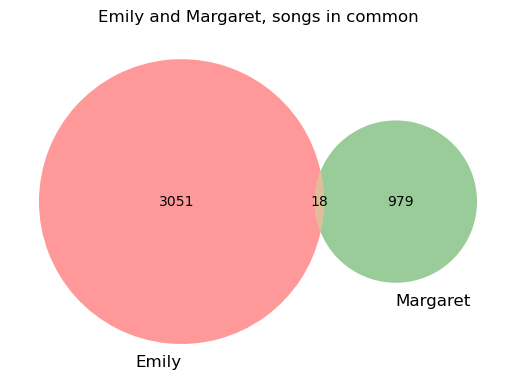

Some songs in common:

['Bravado', 'Everybody', 'The Love Club', 'Tennis Court', 'White Teeth Teens', 'A World Alone']



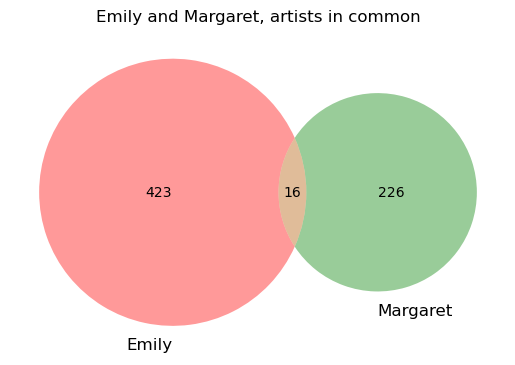

Some artists in common:

['Bruno Mars', 'David Guetta', 'Lana Del Rey', 'Lady Gaga', 'Cardi B', 'Beyoncé']



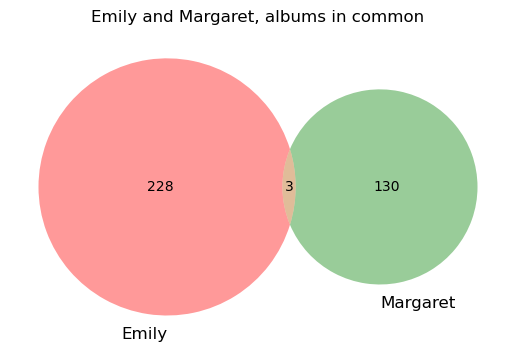

Albums in common:

['Pure Heroine', 'Invasion of Privacy', 'folklore']



In [19]:
for i in range(len(volunteers)):
    banned_flag(volunteers[i])
    make_venns(volunteers[i])

# Wrapped data

In [21]:
with open("Emily/Wrapped2024.json", "r") as f:
    data = json.load(f)
if isinstance(data, dict):
    print("Top-level keys:", data.keys())

display(data)

my_artists[my_artists["uri"] == "spotify:artist:70kkdajctXSbqSMJbQO424"]
my_tracks[my_tracks["uri"] == 'spotify:track:78SjYKRXdivtTDHBzaehnm']

display(pd.DataFrame(data["musicEvolution"]["eras"]))
# there's a column in that df called tracks that I want to pull out and look at

print(type(pd.DataFrame(data["musicEvolution"]["eras"])["tracks"])) # it's a series where each row is a list with dict
temp_series = pd.DataFrame(data["musicEvolution"]["eras"])["tracks"] # name it to make the next thing simpler

flat_dicts = temp_series.apply(lambda x: x[0])  
display(pd.DataFrame(flat_dicts.tolist()))

# display(pd.DataFrame(data["musicEvolution"]["eras"])["genre"])
my_genres = pd.DataFrame(data["musicEvolution"]["eras"])["genre"]
print(type(my_genres))
my_genres

Top-level keys: dict_keys(['topArtists', 'topTracks', 'yearlyMetrics', 'musicEvolution'])


{'topArtists': {'numUniqueArtists': 676,
  'topArtists': [{'artistUri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'},
   {'artistUri': 'spotify:artist:70kkdajctXSbqSMJbQO424'},
   {'artistUri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'},
   {'artistUri': 'spotify:artist:66lH4jAE7pqPlOlzUKbwA0'},
   {'artistUri': 'spotify:artist:3RqBeV12Tt7A8xH3zBDDUF'}],
  'topArtistMilliseconds': 375219037,
  'topArtistFanPercentage': 0.009729186},
 'topTracks': {'topTracks': ['spotify:track:78SjYKRXdivtTDHBzaehnm',
   'spotify:track:27RDQ0TfxzWMlQFuKrPT11',
   'spotify:track:333XFHKsHU0pOocFzBgrJi',
   'spotify:track:6f2unaaUhIqTkbHsWMbGcm',
   'spotify:track:1LwT9Pou0rRCXPpXVWy5iA'],
  'topTrackPlayCount': 150,
  'topTrackFirstPlayedDate': '2024-03-15',
  'distinctTracksPlayed': 2689},
 'yearlyMetrics': {'totalMsListened': 2594738827,
  'mostListenedDay': '2024-03-22',
  'mostListenedDayMinutes': 572.7955,
  'percentGreaterThanWorldwideUsers': 94.03808},
 'musicEvolution': {'eras': [{'key': '0',
    'peak

,key,peakMonth,color,genre,mood,descriptor,pivotalArtists,tracks
0,0,1,green-blue,country,breakup,tavern,"[spotify:artist:66lH4jAE7pqPlOlzUKbwA0, spotif...","[{'trackName': 'No Man's Land', 'trackUri': 's..."
1,1,3,yellow,americana,golden hour,folkie,"[spotify:artist:70kkdajctXSbqSMJbQO424, spotif...","[{'trackName': 'Anime Eyes', 'trackUri': 'spot..."
2,2,4,yellow,pop,mcbling,vogue,"[spotify:artist:06HL4z0CvFAxyc27GXpf02, spotif...","[{'trackName': 'AMERIICAN REQUIEM', 'trackUri'..."


<class 'pandas.core.series.Series'>


,trackName,trackUri
0,No Man's Land,spotify:track:161YJMujRNIZNYn01GSDTs
1,Anime Eyes,spotify:track:0bUsZ520JrK3cqkXXaXYXd
2,AMERIICAN REQUIEM,spotify:track:6K2Iut8nSQigP83yvbiqi8


<class 'pandas.core.series.Series'>


0      country
1    americana
2          pop
Name: genre, dtype: object

In [22]:
# Krissy's data is truncated for some reason, compared to mine
with open("Krissy/Wrapped2024.json", "r") as f:
    data = json.load(f)
if isinstance(data, dict):
    print("Top-level keys:", data.keys())

display(data)
"musicEvolution" in list(data.keys())

Top-level keys: dict_keys(['topArtists', 'topTracks', 'yearlyMetrics'])


{'topArtists': {'numUniqueArtists': 662,
  'topArtists': [{'artistUri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'},
   {'artistUri': 'spotify:artist:7GlBOeep6PqTfFi59PTUUN'},
   {'artistUri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'},
   {'artistUri': 'spotify:artist:6yDo1kCCuaAyfUy37qTiih'},
   {'artistUri': 'spotify:artist:2i0yWCXBGhBWuT0qnM3tmE'}],
  'topArtistMilliseconds': 28114444,
  'topArtistFanPercentage': 0.09885333},
 'topTracks': {'topTracks': ['spotify:track:3hUxzQpSfdDqwM3ZTFQY0K',
   'spotify:track:1dGr1c8CrMLDpV6mPbImSI',
   'spotify:track:1iWHabUgUuuKLBa0TzTHfk',
   'spotify:track:1OYOLWqKmhkFIx2KC9ek1a',
   'spotify:track:760jhRscwGbIIe1m1IIQpU'],
  'topTrackPlayCount': 11,
  'topTrackFirstPlayedDate': '2024-02-07',
  'distinctTracksPlayed': 2759},
 'yearlyMetrics': {'totalMsListened': 595877894,
  'mostListenedDay': '2024-06-30',
  'mostListenedDayMinutes': 580.4491,
  'percentGreaterThanWorldwideUsers': 68.24402}}

False

In [23]:
with open("Emily/Wrapped2024.json", "r") as f:
    data = json.load(f)

"musicEvolution" in list(data.keys())

True

In [24]:
print("Genres:")
for i in range(len(everyone)):
    print(everyone[i], ": ", list(find_top_genres(everyone[i])), sep = "")
print()
print("Moods:")
for i in range(len(everyone)):
    print(everyone[i], ": ", list(find_top_moods(everyone[i])), sep = "")

print()
print("Descriptors:")
for i in range(len(everyone)):
    print(everyone[i], ": ", list(find_top_descriptors(everyone[i])), sep = "")

Genres:
Sidney: ['christian hip hop', 'jazz', 'classical']
Kelsey: ['pop', 'soundtrack', 'classical']
Ashley: ['r&b', 'pop', 'power ballad']
Robin: ['indie folk', 'minimalism', 'ambient']
Dan: ['alternative r&b', 'pop', 'emo']
Jenn: ['indie', 'rap', 'reggae rock']
Alex: ['south african hip hop', 'reggae', 'australian indie']
Matt: ['hauntology', 'lo-fi', 'indie']
Krissy: []
Hali: ['madrigal', 'pop', 'love song']
Celina: ['yacht rock', 'new jack swing', 'pop']
Amanda: ['lo-fi', 'soundtrack', 'indie']
Diane: []
Margaret: ['salsa', 'pop', 'americana']
Emily: ['country', 'americana', 'pop']

Moods:
Sidney: ['golden hour', 'speakeasy', 'royalcore']
Kelsey: ['pink pilates princess', 'theatrical', 'light academia']
Ashley: ['softie', 'joyride', 'indie sleaze']
Robin: ['mellow rock', 'theatrical', 'atmospheric']
Dan: ['frutiger aero', 'pumpkin spice', 'mallgoth']
Jenn: ['serotonin', 'boujee', 'chill']
Alex: ['indie sleaze', 'surf crush', 'van life']
Matt: ['liminal', 'nerdy', 'surf crush']
Kri

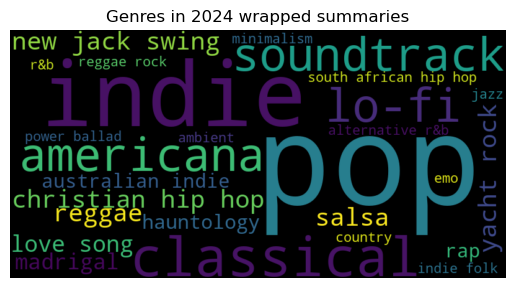

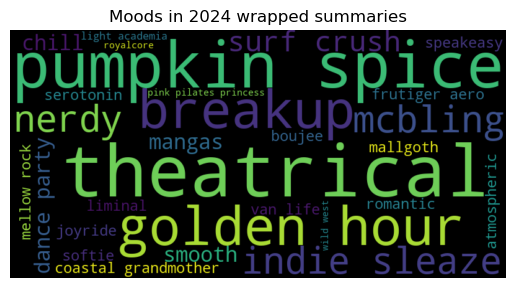

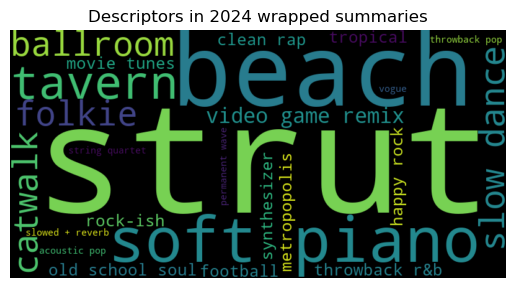

In [25]:
# Word clouds of the categories from the wrapped data

all_genres = pd.Series()
for i in range(len(everyone)): # go through everyone in the list
    all_genres = pd.concat([all_genres, find_top_genres(everyone[i])], ignore_index=True) # add their genres to the list

word_freq = dict(all_genres.value_counts())

# Create and display word cloud
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(label = "Genres in 2024 wrapped summaries")
plt.show()

all_moods = pd.Series()
for i in range(len(everyone)): # go through everyone in the list
    all_moods = pd.concat([all_moods, find_top_moods(everyone[i])], ignore_index=True)

word_freq = dict(all_moods.value_counts())

# Create and display word cloud
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(label = "Moods in 2024 wrapped summaries")
plt.show()

all_descriptors = pd.Series()
for i in range(len(everyone)): # go through everyone in the list
    all_descriptors = pd.concat([all_descriptors, find_top_descriptors(everyone[i])], ignore_index=True)

word_freq = dict(all_descriptors.value_counts())

# Create and display word cloud
wc = WordCloud(width=800, height=400)
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(label = "Descriptors in 2024 wrapped summaries")
plt.show()

# Streaming history

In [27]:
# this data set is not multidimensional so I can import it right into pandas
my_streams = pd.read_json("Emily/StreamingHistory_music_0.json")
print(my_streams.columns)
display(my_streams.head())
np.sum(my_streams["msPlayed"]) # milisecond
np.sum(my_streams["msPlayed"]/1000/60/60) # hours

Index(['endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object')


,endTime,artistName,trackName,msPlayed
0,2024-04-09 16:14,The Verve,Bitter Sweet Symphony - Remastered 2016,457744
1,2024-04-09 16:17,Diplo,So Long (feat. Cam),172773
2,2024-04-09 16:20,Chris Avantgarde,Inside,155500
3,2024-04-09 16:23,Cam,Happier For You,231560
4,2024-04-09 16:27,Cam,Hungover On Heartache,193480


472.8452997222222

In [28]:
my_streams_2 = pd.read_json("Emily/StreamingHistory_music_1.json")
display(my_streams_2.head())
np.sum(my_streams_2["msPlayed"]) # milisecond
np.sum(my_streams_2["msPlayed"]/1000/60/60) # hours

,endTime,artistName,trackName,msPlayed
0,2025-02-20 16:42,Sabrina Carpenter,Please Please Please,133542
1,2025-02-20 16:46,Sabrina Carpenter,Sharpest Tool,218284
2,2025-02-20 16:49,Sabrina Carpenter,Espresso,175459
3,2025-02-20 16:52,Sabrina Carpenter,Juno,223192
4,2025-02-20 16:55,Sabrina Carpenter,Taste,157279


90.19544416666668

## Listening hours

In [30]:
music_hours("Dan")

1287.81

Total music hours in the past year:

Sidney: 88.64
Kelsey: 179.8
Ashley: 181.21
Robin: 69.77
Dan: 1287.81
Jenn: 833.37
Alex: 46.18


/var/folders/84/7fnlc30d2dl92_2kyb8f3q9h0000gn/T/ipykernel_66306/2664166362.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  music_hours_df = pd.concat([music_hours_df, new_row], ignore_index=True)


Matt: 476.69
Krissy: 233.38
Hali: 20.61
Celina: 357.97
Amanda: 315.65
Diane: 4.66
Margaret: 239.08
Emily: 563.04


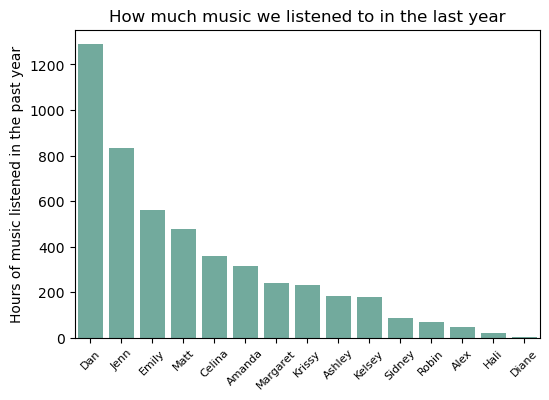

Total podcast hours in the past year:

Sidney: 0.01
Kelsey: 0.04
Ashley: 7.97
Robin: 0.0
Dan: 83.98
Jenn: 0.04
Alex: 118.02
Matt: 0.24
Krissy: 0.0
Hali: 529.1
Celina: 0.01
Amanda: 979.46
Diane: 0.0
Margaret: 251.1
Emily: 0.04


Total audiobook hours in the past year:

Sidney: 0.0
Kelsey: 0.0
Ashley: 0.0
Robin: 0.0
Dan: 9.4
Jenn: 0.0
Alex: 0.0
Matt: 0.0
Krissy: 0.01
Hali: 0.0
Celina: 8.41
Amanda: 0.0
Diane: 0.0
Margaret: 37.39
Emily: 0.32


In [31]:
music_hours_df = pd.DataFrame(columns = ("Listener", "Hours"))

display(Markdown("Total music hours in the past year:"))
for i in range(len(everyone)):
    print(everyone[i], ": ", music_hours(everyone[i]), sep="")
    new_row = list([everyone[i], music_hours(everyone[i])])
    new_row = pd.DataFrame([new_row], columns = music_hours_df.columns)
    music_hours_df = pd.concat([music_hours_df, new_row], ignore_index=True)
    
music_hours_df = music_hours_df.sort_values(by=["Hours"], axis="rows", ascending=False)
plt.figure(figsize=(6,4))
plt.xticks(rotation = 45, size=8)

# Make a barplot
sns.barplot(
    x="Listener", 
    y="Hours", 
    data=music_hours_df, 
    # order=music_hours_df["Hours"],
    errorbar=None, 
    color='#69b3a2'
)
plt.ylabel("Hours of music listened in the past year")
plt.xlabel("")
plt.title("How much music we listened to in the last year")
plt.show()
    

display(Markdown("Total podcast hours in the past year:"))
for i in range(len(everyone)):
    print(everyone[i], ": ", pod_hours(everyone[i]), sep="")

display(Markdown("Total audiobook hours in the past year:"))
for i in range(len(everyone)):
    print(everyone[i], ": ", audiobook_hours(everyone[i]), sep="")

## Artists, songs, and listening diversity

In [33]:
for i in range(len(everyone)):
    print(everyone[i], "listened to", len(past_year_artists(everyone[i])), "artists in the past year")
print()
for i in range(len(everyone)):
    artists = len(past_year_artists(everyone[i]))
    hours = music_hours(everyone[i])
    res = artists/hours
    print(everyone[i], "listened to", round(res, 2), "artists per hour in the past year")

Sidney listened to 750 artists in the past year
Kelsey listened to 1171 artists in the past year
Ashley listened to 884 artists in the past year
Robin listened to 412 artists in the past year
Dan listened to 1733 artists in the past year
Jenn listened to 1614 artists in the past year
Alex listened to 400 artists in the past year
Matt listened to 2662 artists in the past year
Krissy listened to 1700 artists in the past year
Hali listened to 157 artists in the past year
Celina listened to 1607 artists in the past year
Amanda listened to 2079 artists in the past year
Diane listened to 39 artists in the past year
Margaret listened to 627 artists in the past year
Emily listened to 437 artists in the past year

Sidney listened to 8.46 artists per hour in the past year
Kelsey listened to 6.51 artists per hour in the past year
Ashley listened to 4.88 artists per hour in the past year
Robin listened to 5.91 artists per hour in the past year
Dan listened to 1.35 artists per hour in the past year

In [34]:
for i in range(len(everyone)):
    print(everyone[i], "listened to", len(past_year_songs(everyone[i])), "unique songs in the past year")
print()
for i in range(len(everyone)):
    nsongs = len(past_year_songs(everyone[i]))
    hours = music_hours(everyone[i])
    res = nsongs/hours
    print(everyone[i], "listened to", round(res, 2), "songs per hour in the past year")

Sidney listened to 1316 unique songs in the past year
Kelsey listened to 2663 unique songs in the past year
Ashley listened to 1698 unique songs in the past year
Robin listened to 916 unique songs in the past year
Dan listened to 6392 unique songs in the past year
Jenn listened to 4302 unique songs in the past year
Alex listened to 841 unique songs in the past year
Matt listened to 6773 unique songs in the past year
Krissy listened to 3320 unique songs in the past year
Hali listened to 362 unique songs in the past year
Celina listened to 3000 unique songs in the past year
Amanda listened to 3728 unique songs in the past year
Diane listened to 68 unique songs in the past year
Margaret listened to 1505 unique songs in the past year
Emily listened to 2387 unique songs in the past year

Sidney listened to 14.85 songs per hour in the past year
Kelsey listened to 14.81 songs per hour in the past year
Ashley listened to 9.37 songs per hour in the past year
Robin listened to 13.13 songs per ho

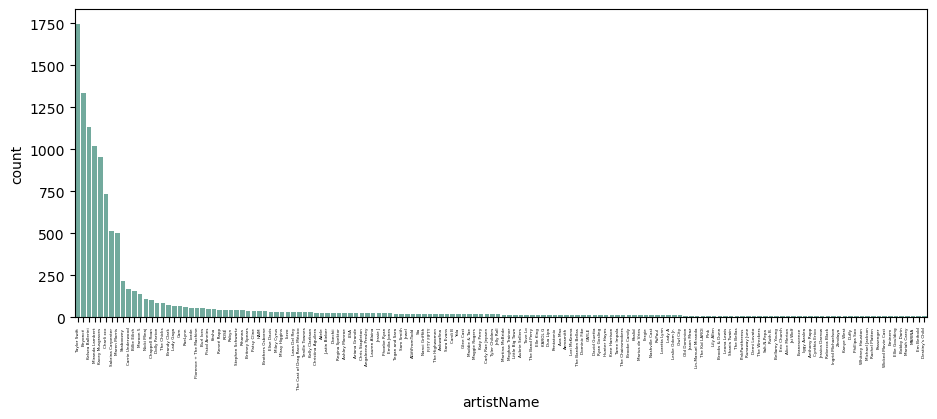

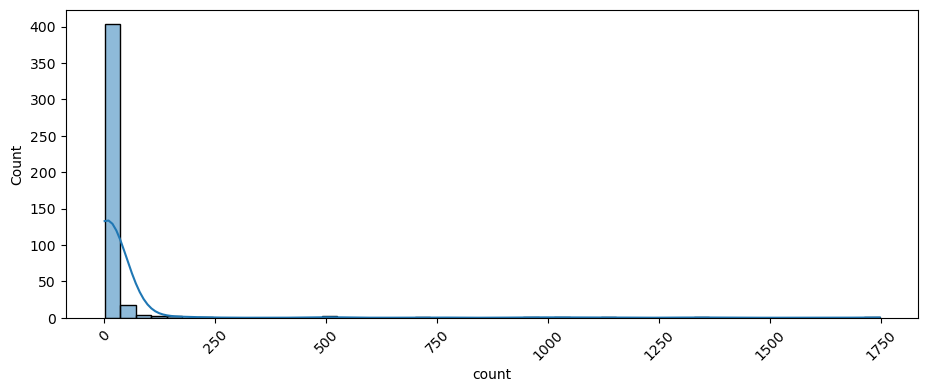

In [35]:
my_history = stream_history("Emily")
# display(my_history.head())
my_history["artistName"].value_counts()
df = pd.DataFrame(my_history["artistName"].value_counts())
# display(df.head())
df = df.reset_index()
# display(df.head())

plt.figure(figsize=(11,4))
plt.xticks(rotation = 90, size=3)

# Make a barplot
sns.barplot(
    x="artistName", 
    y="count", 
    data=df.iloc[0:150,], 
    estimator=sum, 
    errorbar=None, 
    color='#69b3a2'
)
plt.show()

# Set the figure size
plt.figure(figsize=(11,4))
plt.xticks(rotation = 45, size=10)

sns.histplot(data=df, x="count", kde=True, bins=50)
# plt.show()
# sns.histplot(data=my_history, x="artistName", kde=True)
plt.show()

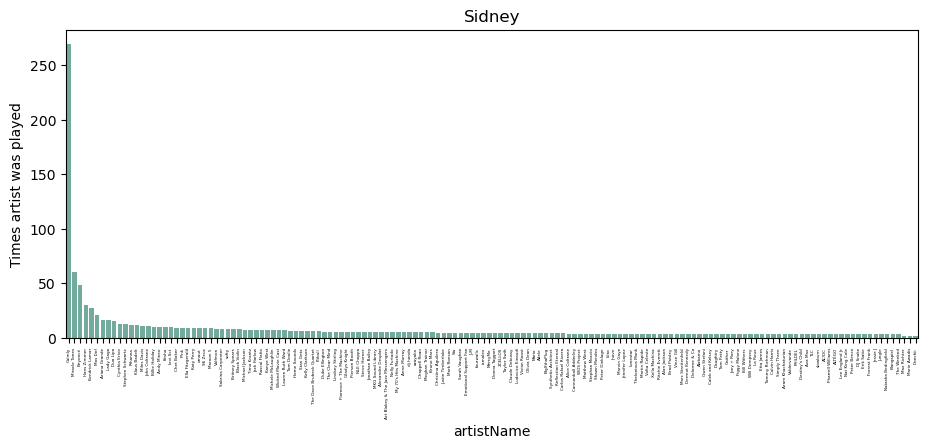

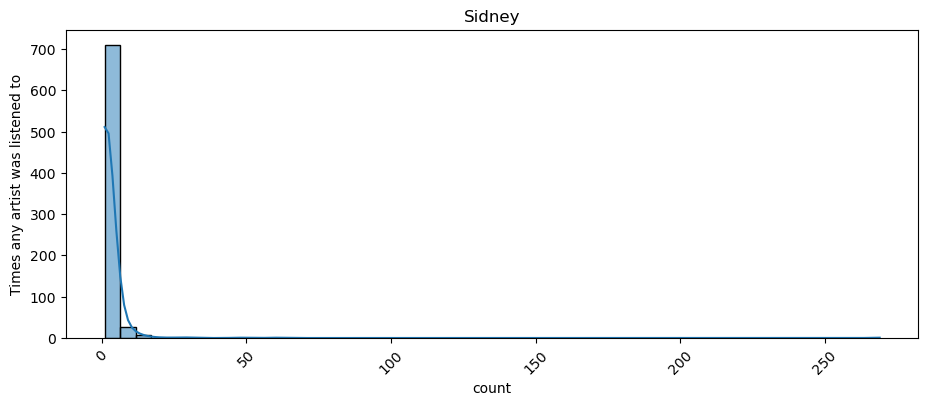

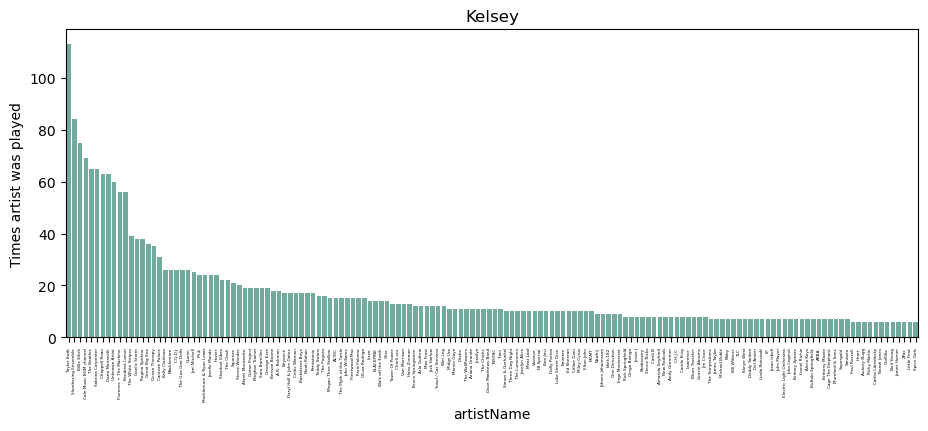

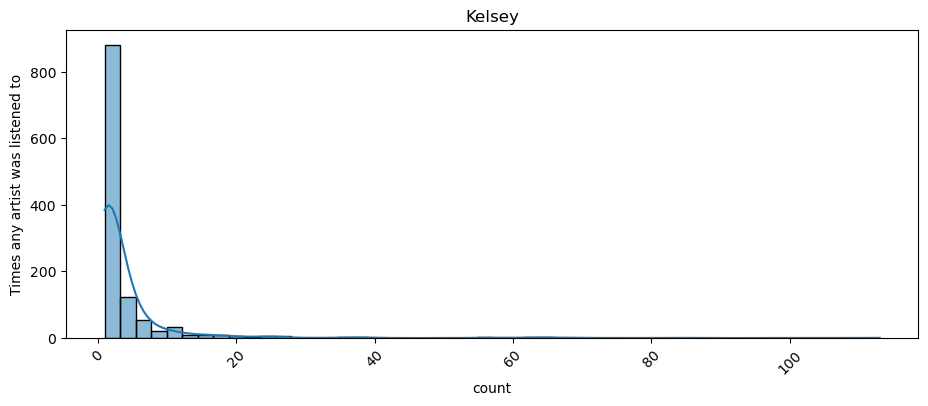

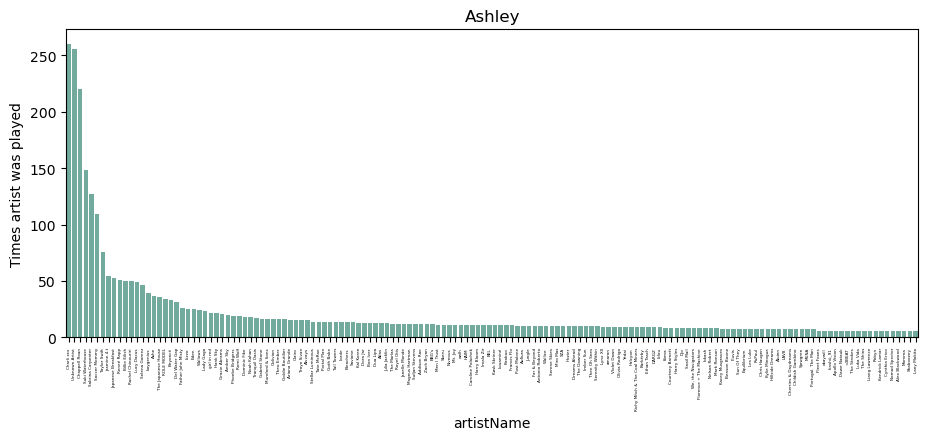

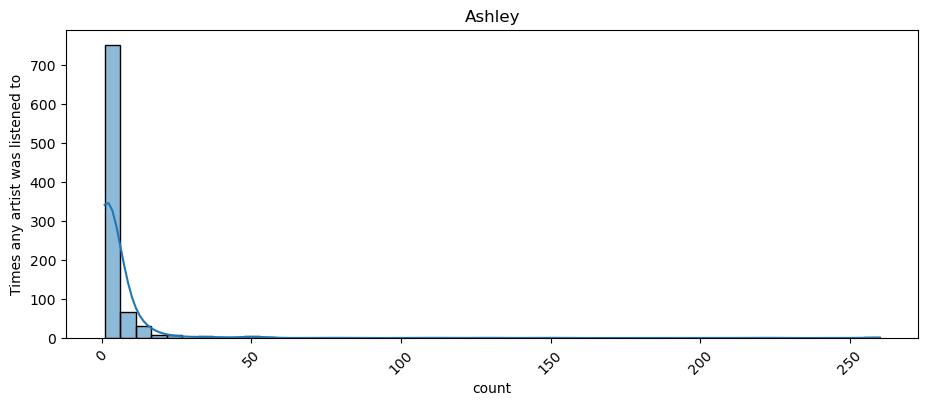

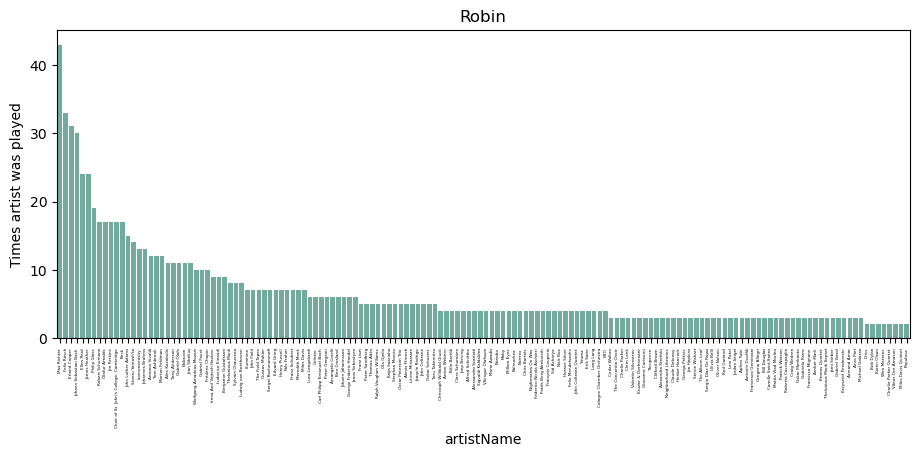

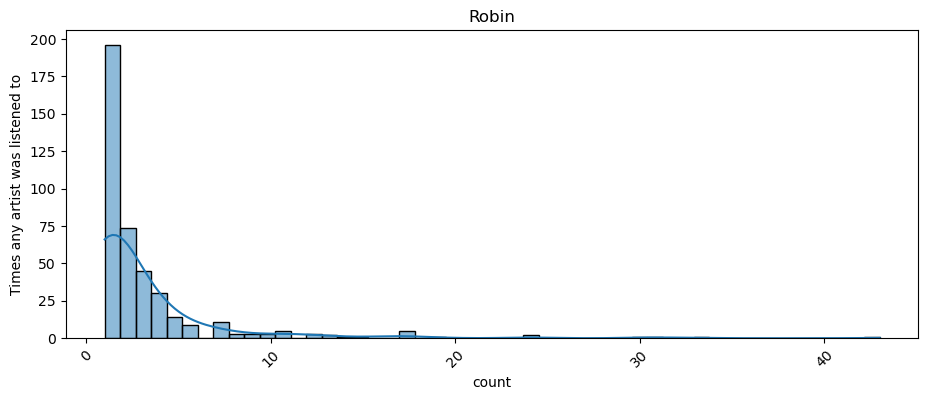

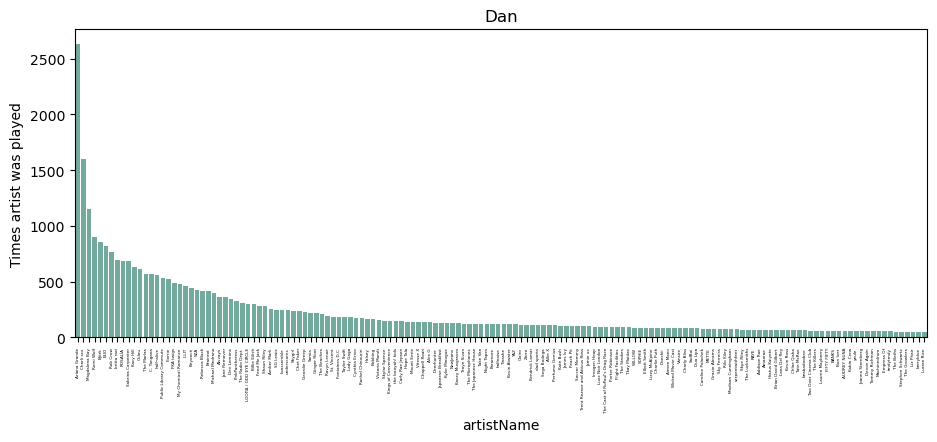

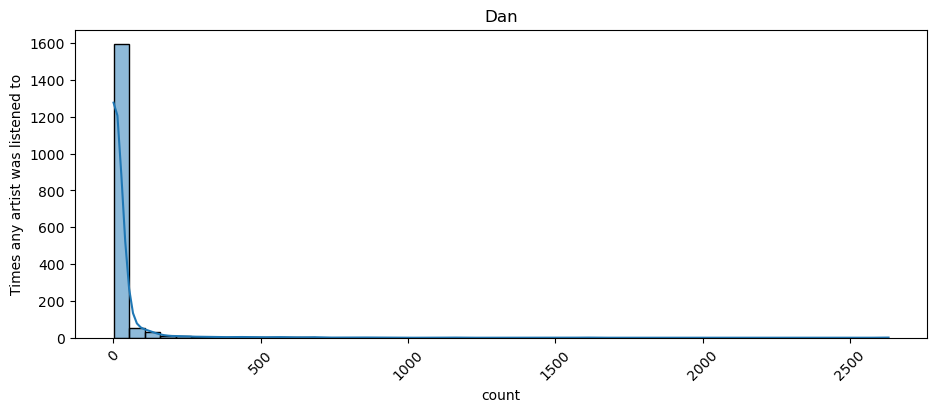

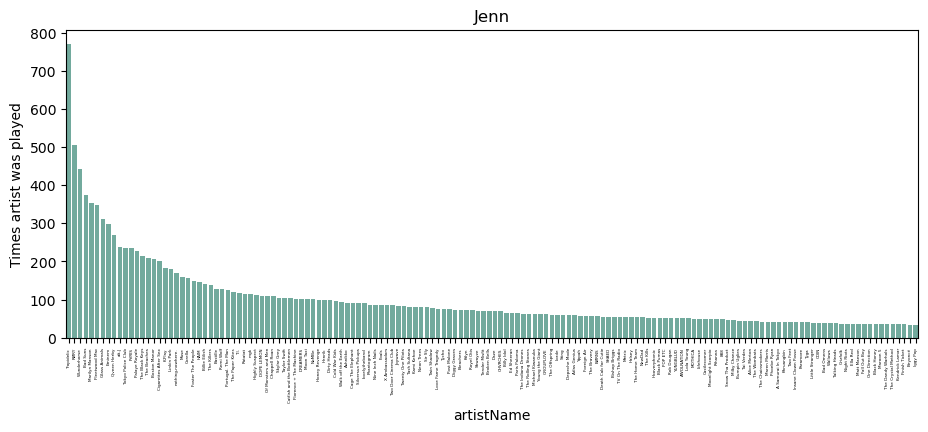

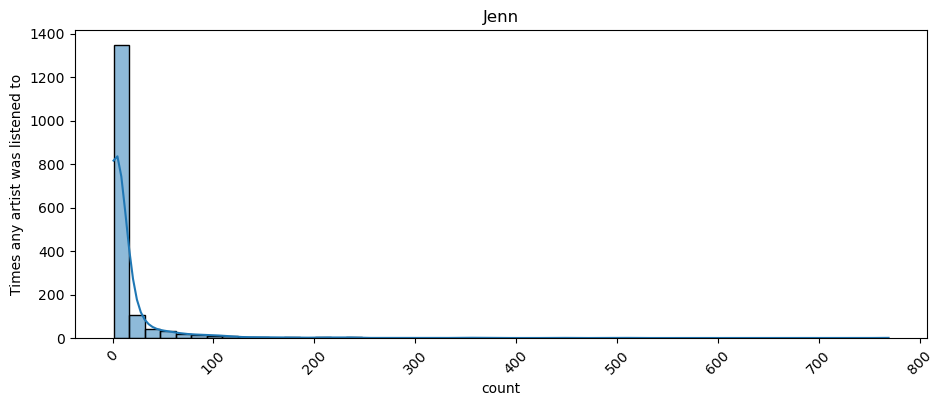

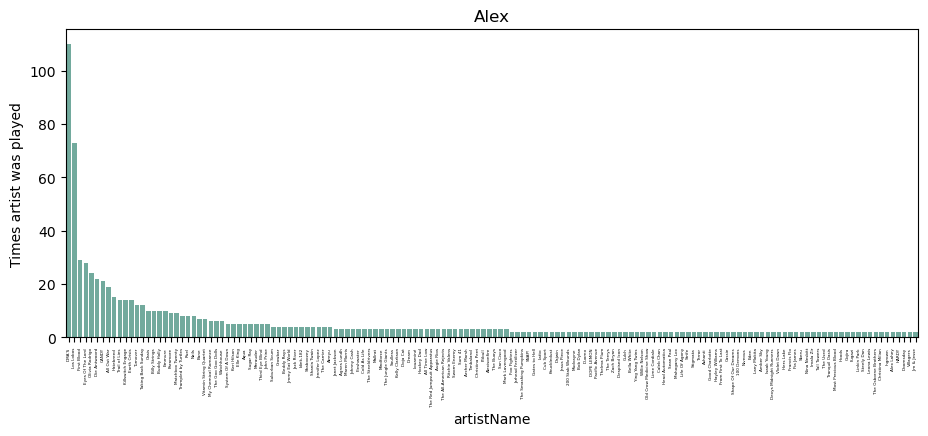

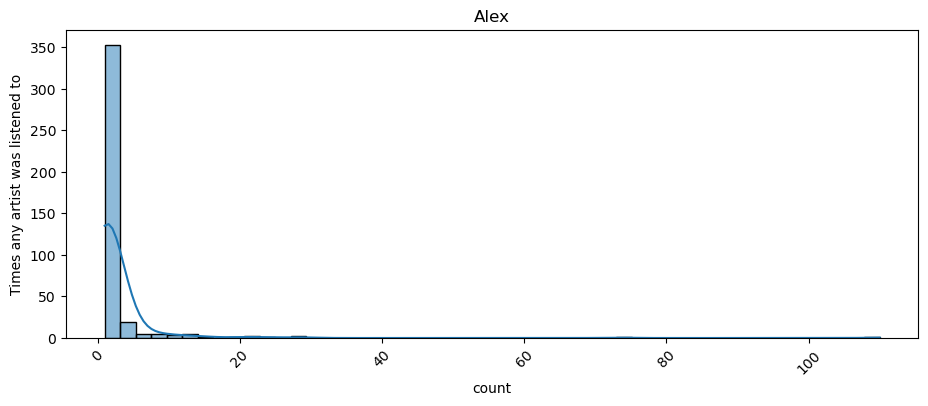

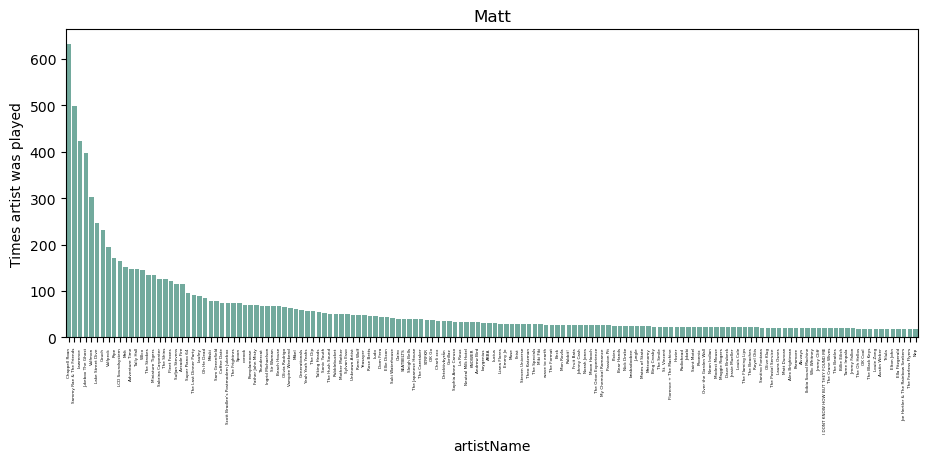

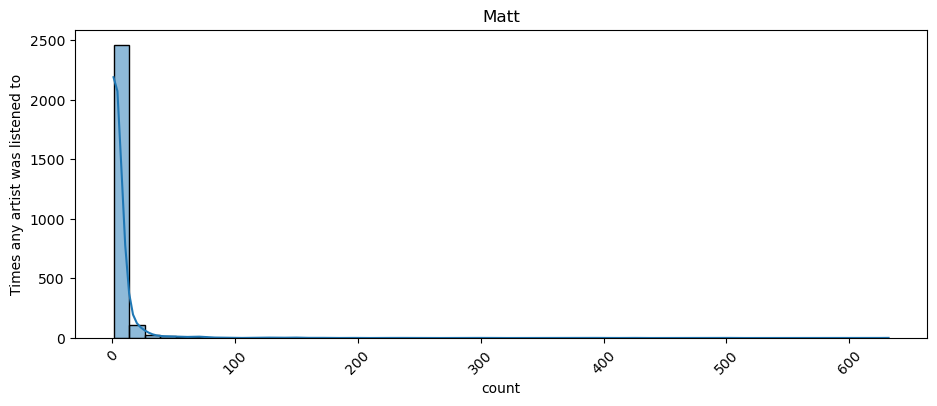

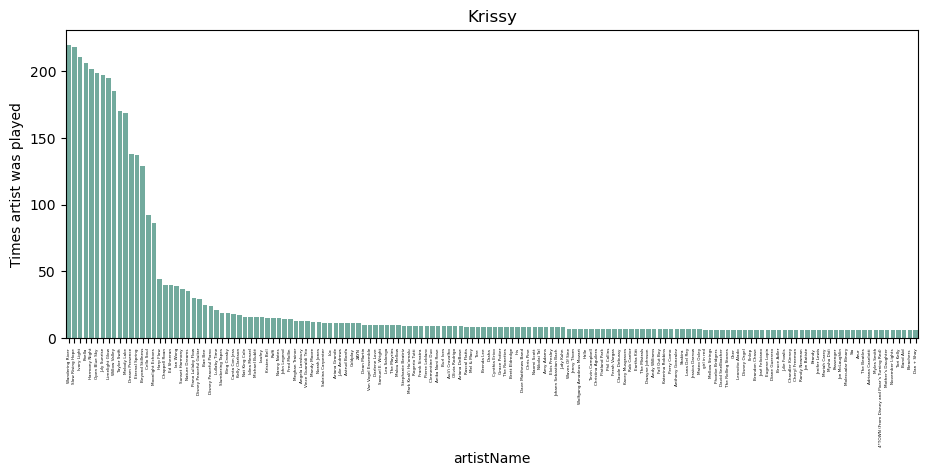

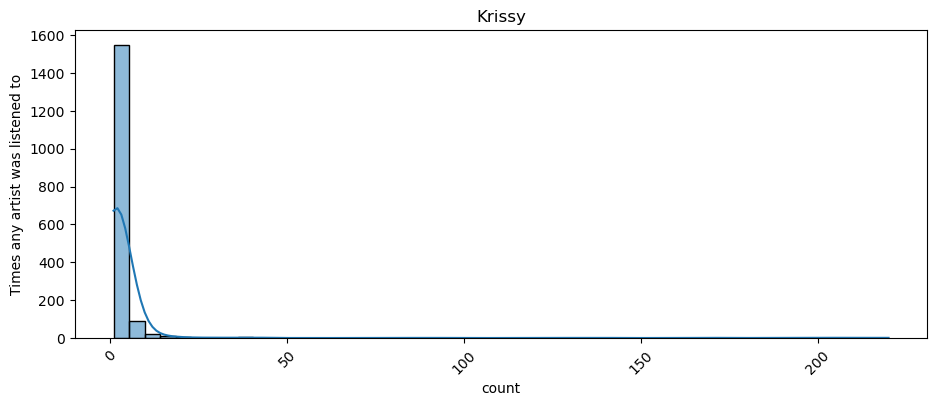

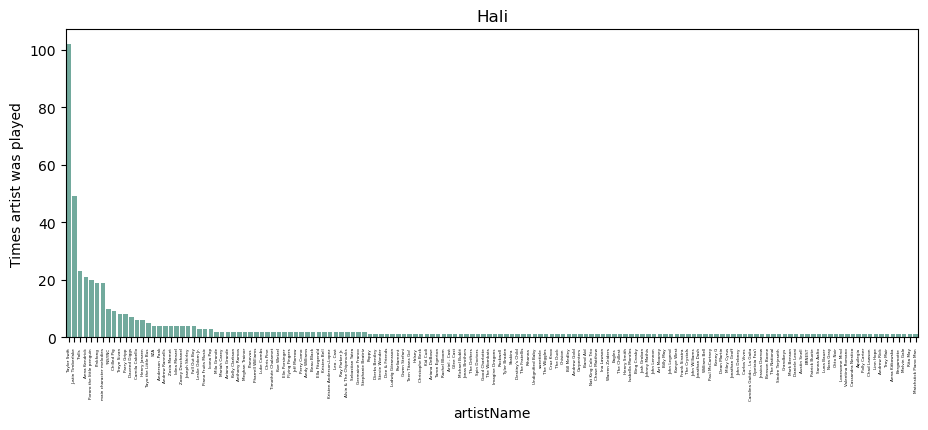

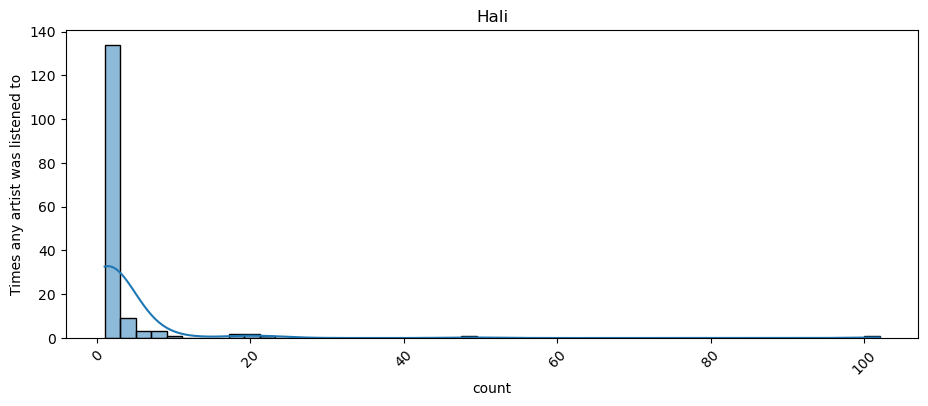

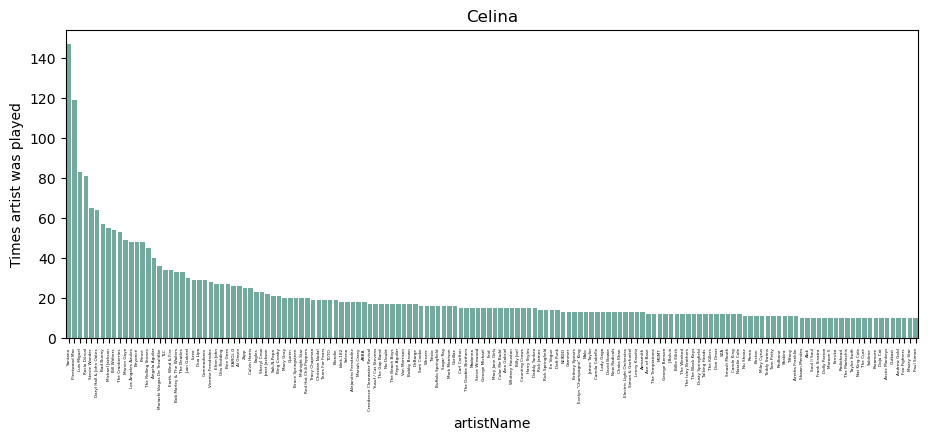

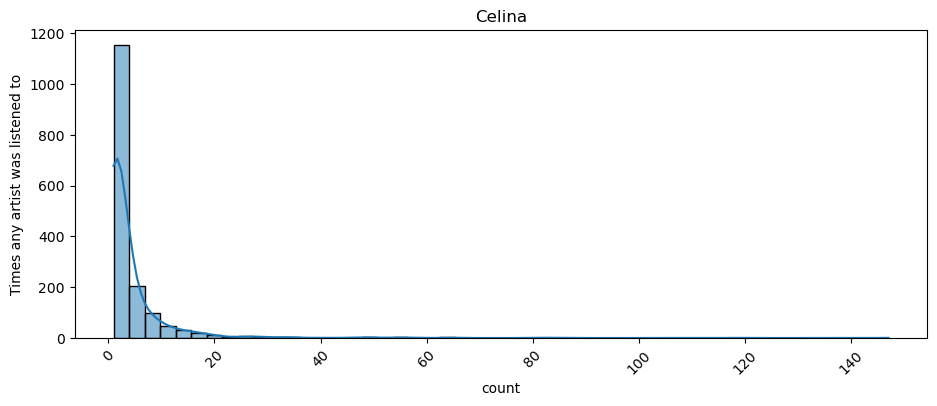

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 34276 (\N{CJK UNIFIED IDEOGRAPH-85E4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36948 (\N{CJK UNIFIED IDEOGRAPH-9054}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20063 (\N{CJK UNIFIED IDEOGRAPH-4E5F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


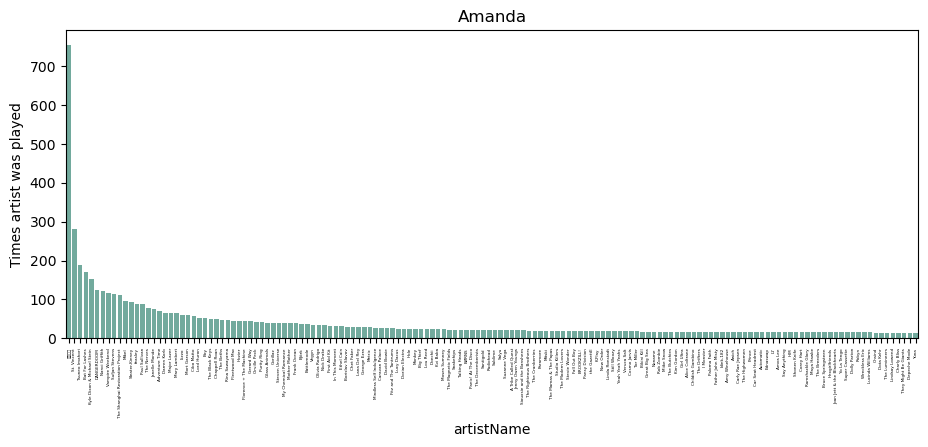

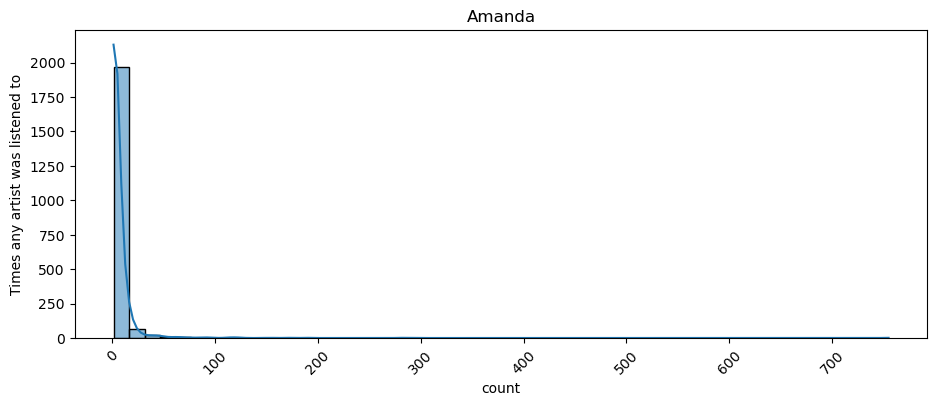

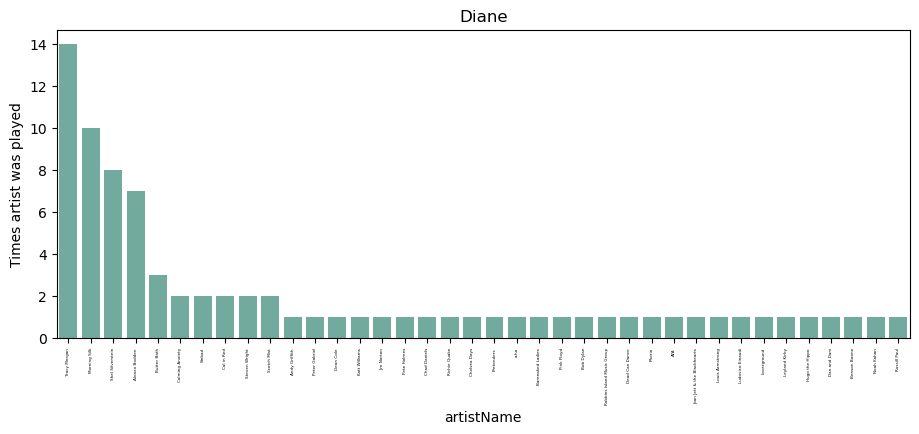

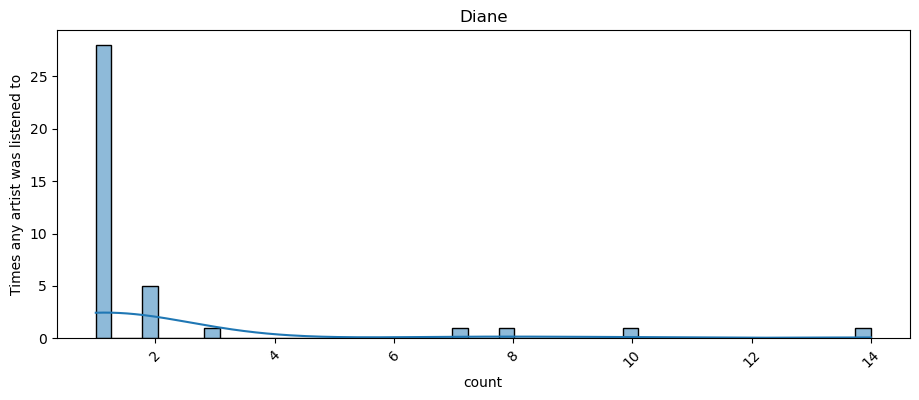

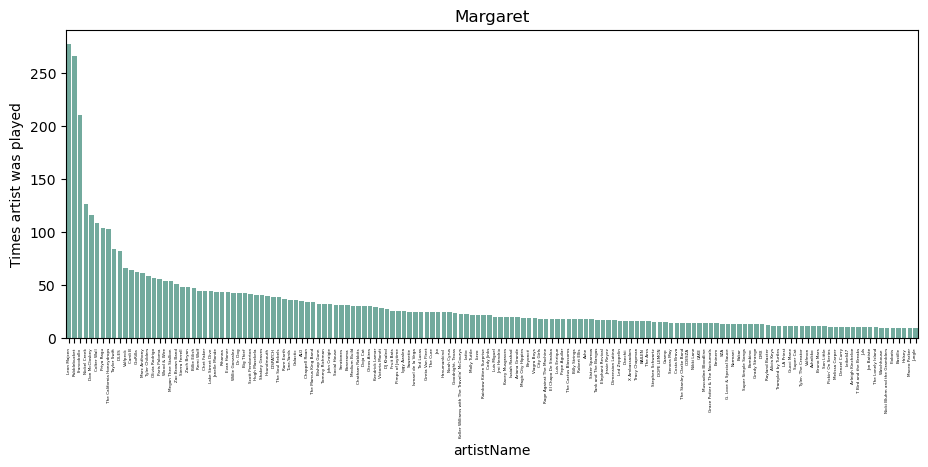

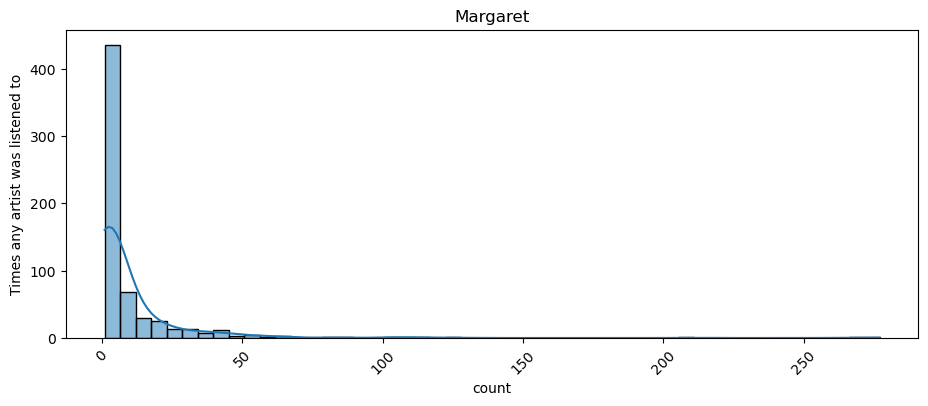

In [36]:
for i in range(len(volunteers)):
    history = stream_history(volunteers[i])
    # display(my_history.head())
    # my_history["artistName"].value_counts()
    df = pd.DataFrame(history["artistName"].value_counts())
    df = df.reset_index()
    # print(volunteers[i])
    # display(df.head())    
    plt.figure(figsize=(11,4))
    plt.xticks(rotation = 90, size=3)
    
    # Make a barplot
    sns.barplot(
        x="artistName", 
        y="count", 
        data=df.iloc[0:150,], 
        estimator=sum, 
        errorbar=None, 
        color='#69b3a2'
    )
    plt.ylabel("Times artist was played")
    plt.title(volunteers[i])
    plt.show()
    
    # Histogram
    plt.figure(figsize=(11,4))
    plt.xticks(rotation = 45, size=10)
    plt.ylabel("Times any artist was listened to")
    plt.title(volunteers[i])
    
    sns.histplot(data=df, x="count", kde=True, bins=50)
    # plt.show()
    # sns.histplot(data=my_history, x="artistName", kde=True)
    plt.show()

In general, most people listen to a few artists a lot of times, and a lot of artists a few times. I'm kind of surprised! I probably would have guessed there would be a more normal distribution, with a medium amount of artists listened to a medium amount of times, but no one shows that pattern

In [38]:
# Most common artists
everyone_artists = pd.DataFrame(columns=(["artistName","listener"]))
for i in range(len(everyone)):
    strm = stream_history(everyone[i])
    temp = pd.DataFrame(strm["artistName"].unique())
    # print(temp.head())
    temp.columns = (["artistName"])
    temp["listener"] = everyone[i]
    everyone_artists = pd.concat([everyone_artists, temp])

print("Most popular artists")
print("Number of people who have played them in the last year")
print("Out of", len(everyone), "people")
everyone_artists["artistName"].value_counts()[0:25]

Most popular artists
Number of people who have played them in the last year
Out of 15 people


artistName
Taylor Swift              13
Ariana Grande             13
Fall Out Boy              12
Kesha                     12
Miley Cyrus               11
TLC                       11
Sia                       11
Billie Eilish             11
Rihanna                   11
Sabrina Carpenter         11
Dua Lipa                  11
Chappell Roan             11
Green Day                 10
Hozier                    10
Lady Gaga                 10
Selena Gomez              10
Olivia Rodrigo            10
Noah Kahan                10
Lizzo                     10
Florence + The Machine    10
SZA                       10
Britney Spears            10
Kanye West                10
Charli xcx                10
Remi Wolf                  9
Name: count, dtype: int64

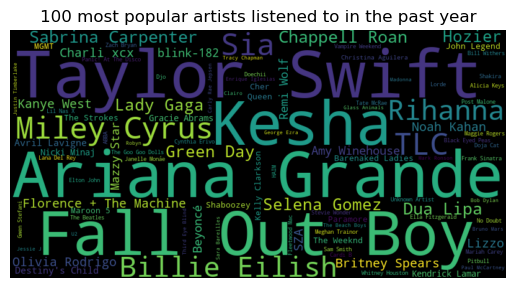

In [39]:
# Everyone's most played artists word cloud
df = pd.DataFrame(everyone_artists["artistName"].value_counts())
df = df.reset_index()
df.head()

word_freq = dict(zip(df["artistName"], df["count"]))

wc = WordCloud(width=800, height=400, max_words=100)
wc.generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(label = "100 most popular artists listened to in the past year")
plt.show()

# Playlists

In [41]:
with open("Emily/Playlist1.json", "r") as f:
    data = json.load(f)
if isinstance(data, dict):
    print("Top-level keys:", data.keys())

# display(data)
# pd.read_json("Emily/Playlist1.json")
df = pd.DataFrame(data["playlists"])
# display(df[df["numberOfFollowers"] > 1])

# It's only playlists I've made, not playlists I saved... not that interesting

Top-level keys: dict_keys(['playlists'])


# Misc data to peek at

In [43]:
# Look at all the files to remember what I have
os.listdir("Emily")

['DuoNewFamily.json',
 'Follow.json',
 'Inferences.json',
 'Marquee.json',
 'StreamingHistory_podcast_0.json',
 'Userdata.json',
 'StreamingHistory_music_1.json',
 'StreamingHistory_music_0.json',
 'SearchQueries.json',
 'Wrapped2024.json',
 'Playlist1.json',
 'YourLibrary.json',
 'Marqee_short.json',
 'Payments.json',
 'Extended',
 '.ipynb_checkpoints',
 'Inferences_generic.json',
 'Read_Me_First.pdf',
 'SearchQueries_one.json',
 'StreamingHistory_audiobook_0.json',
 'Identifiers.json']

In [44]:
with open("Emily/DuoNewFamily.json", "r") as f:
    data = json.load(f)
data # this has my address, what a weird name for the file
with open("Emily/Follow.json", "r") as f:
    data = json.load(f)
data # number of followers, nothing that interesting
with open("Emily/Userdata.json", "r") as f:
    data = json.load(f)
data # contact info
with open("Emily/SearchQueries.json", "r") as f:
    data = json.load(f)
# with open('Emily/SearchQueries_one.json', 'w') as f:
#     json.dump(data[0], f)
with open("Emily/Identifiers.json", "r") as f:
    data = json.load(f)
data # email address
with open("Emily/Marquee.json", "r") as f:
    data = json.load(f)
# with open('Emily/Marqee_short.json', 'w') as f:
#     json.dump(data[0:6], f)

In [45]:
# I have an idea that I might post this data to Kaggle as an example set for other coders to work on
# So there are some files I will just exclude (e.g., payment history). This one seemed easy to clean for the upload

with open("Emily/Inferences.json", "r") as f:
    data = json.load(f)
# print(data)
# Making up examples based on my data
df = pd.DataFrame({
        'inferences': ["1P_Custom_example-category", "content_audiobooks", "content_music", "content-example", 
                       "demographic_example-category", "interest_academic-interests", "interest_books-and-literature", "interest_example"],
})
# df.to_json("Emily/Inferences_generic.json")

# Extended data

The extended data package from Spotify takes up to 30 days to prepare so I asked my volunteers for only the basic data package. I requested my own data first, with enough lead time, so I have that data for myself

In [48]:
os.listdir("Emily/Extended")
with open(("Emily/Extended/"+os.listdir("Emily/Extended")[0]), "r") as f:
    data = json.load(f)
# print(data)
df = pd.DataFrame(columns = pd.DataFrame(data).columns)
for i in range(len(os.listdir("Emily/Extended"))):
    temp = pd.read_json(("Emily/Extended/"+os.listdir("Emily/Extended")[i]))
    df = pd.concat([df,temp], ignore_index = True)
# print(df.shape)
print("I have listened to", df["master_metadata_album_artist_name"].nunique(), "artists")
df.head()

I have listened to 3292 artists


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2024-03-22T12:46:17Z,ios,160053,US,73.159.63.236,Too Good to be True,Kacey Musgraves,Deeper Well,spotify:track:27RDQ0TfxzWMlQFuKrPT11,None,...,None,None,None,trackdone,trackdone,True,False,False,1711111416,False
1,2024-03-22T12:48:50Z,ios,153533,US,73.159.63.236,Nothing to be Scared Of,Kacey Musgraves,Deeper Well,spotify:track:36bFdgof0rPVDAv6zcvDIA,None,...,None,None,None,trackdone,trackdone,True,False,False,1711111577,False
2,2024-03-22T12:52:02Z,ios,190973,US,73.159.63.236,Giver / Taker,Kacey Musgraves,Deeper Well,spotify:track:7aWAahCNnOyF1yP547S9fv,None,...,None,None,None,trackdone,trackdone,True,False,False,1711111731,False
3,2024-03-22T12:54:46Z,ios,164026,US,73.159.63.236,Heaven Is,Kacey Musgraves,Deeper Well,spotify:track:5QoAfSCvZEi5ITK1KYTPi4,None,...,None,None,None,trackdone,trackdone,True,False,False,1711111922,False
4,2024-03-22T12:57:46Z,ios,178466,US,73.159.63.236,Jade Green,Kacey Musgraves,Deeper Well,spotify:track:6TAWZcOSkPouh9Tusxv0On,None,...,None,None,None,trackdone,trackdone,True,False,False,1711112087,False


In [49]:
# Get my top 100 most played songs in my history
top = pd.DataFrame(df["spotify_track_uri"].value_counts()).reset_index()
# top.columns = (("spotify_track_uri", "count"))
top.head()
top = top.iloc[0:100,]
# print(top.shape)
# print(df.columns)
track_info = df.loc[:,("spotify_track_uri", "master_metadata_track_name", 
                       "master_metadata_album_artist_name", "master_metadata_album_album_name")].reset_index(drop = True)
# display(track_info)
track_info.drop_duplicates("spotify_track_uri", inplace=True)
top = top.merge(track_info, how="left", on="spotify_track_uri").reset_index(drop = True)
print(top["master_metadata_album_artist_name"].nunique())
# top.to_csv("top_100_all_time.csv", index=False)
top.head()

36


,spotify_track_uri,count,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name
0,spotify:track:2fBvSCdG3lDjImqJvnYtvq,469,Mountain With A View,Kelsea Ballerini,Rolling Up the Welcome Mat
1,spotify:track:3aLD4sG82hq2c1xVpiIkK5,411,New Strings,Miranda Lambert,Kerosene
2,spotify:track:5rCt377EMkCJ0D0sldd5t8,393,Penthouse,Kelsea Ballerini,Rolling Up the Welcome Mat
3,spotify:track:65gLItuJFVkdt3k4ibQMAz,358,Blindsided,Kelsea Ballerini,Rolling Up the Welcome Mat
4,spotify:track:2zhk0kypGeOPsaaZcjyc14,339,Burning House,Cam,Untamed


Here's the resulting playlist! <br>
https://open.spotify.com/playlist/42jO8QUPNgkuikMtD3IPxw?si=c9e3d33c6d754fda


<Axes: title={'center': 'Hours listened per year'}, xlabel='year', ylabel='hours'>

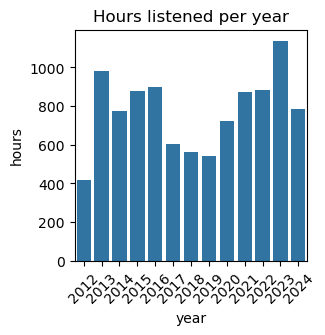

In [51]:
# Listening hours over time
yrs = list()
for i in range(len(df)):
    yrs.append(df["ts"][i].split("-", 1)[0])

# yrs[0:6]
df["year"] = yrs

# I really wanted to practice group_by and agg so this is really exciting, haha
agg_func = {'ms_played': 'sum'}
year_listening = df.groupby(['year']).agg(agg_func)
year_listening.reset_index(inplace=True)
# year_listening
year_listening["hours"] = year_listening["ms_played"]/1000/60/60
# display(year_listening.head())

# print(type(year_listening["year"][0])) # string

# only full years for the plot
plot_dat = year_listening[(year_listening["year"]!="2011") & (year_listening["year"]!="2025")]
# display(plot_dat.head())

# Plot
plt.figure(figsize=(3, 3))
plt.xticks(rotation = 45)
plt.title("Hours listened per year")

sns.barplot(
    x="year", 
    y="hours", 
    data=plot_dat, 
    estimator=sum, 
    errorbar=None
)


In [52]:
# Get my 100 most played artists in my history
top_artists = pd.DataFrame(df["master_metadata_album_artist_name"].value_counts()).reset_index()
# top.columns = (("spotify_track_uri", "count"))
top_artists.head()
top_artists = top_artists.iloc[0:100,]
top_artists
# top_artists.to_csv("top100_artists.csv", index = False)

,master_metadata_album_artist_name,count
0,Taylor Swift,15168
1,Miranda Lambert,14429
2,Kacey Musgraves,9126
3,Kelsea Ballerini,8353
4,Maren Morris,6738
...,...,...
95,Leslie Odom Jr.,440
96,Calvin Harris,438
97,Etta James,431
98,Rachel Platten,425


Taylor Swift is my top-played artist, and yet only shows up twice on the top 100 tracks <br>
I think this means my tendency is to listen to her albums as a whole

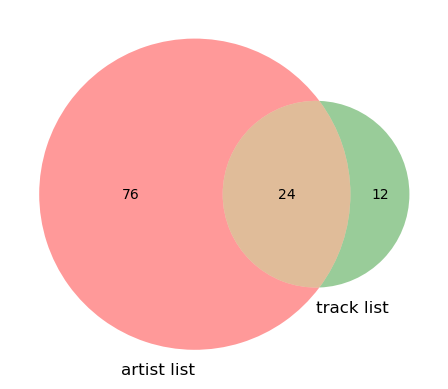

Top artist but no top tracks:
{'The Band Perry', 'Sabrina Carpenter', 'Ashley McBryde', 'Nanci Griffith', 'Kesha', 'Bellamy Young', 'Cardi B', 'Dierks Bentley', 'Yola', 'Jason Isbell and the 400 Unit', 'Patsy Cline', 'Christina Aguilera', 'Maddie & Tae', 'Dolly Parton', 'Florence + The Machine', 'Aubrie Sellers', 'Rihanna', 'David Guetta', 'Ariana Grande', 'Jasmine Thompson', 'The Chicks', 'Jewel', 'Amy Winehouse', 'Tove Lo', 'Demi Lovato', 'Owl City', 'Meghan Trainor', 'Justin Bieber', 'Brandy Clark', 'Adele', 'The Chainsmokers', 'Sara Evans', 'Sia', 'Robyn', 'Kat Dahlia', 'Ingrid Michaelson', 'Miley Cyrus', 'Charli xcx', 'Nicki Minaj', 'Phoebe Ryan', 'Lauren Alaina', 'Billie Eilish', 'Rachel Platten', 'Zendaya', 'Runaway June', 'Anna Nalick', 'Chely Wright', 'The Barden Bellas', 'Britney Spears', 'Chris Stapleton', 'Awkwafina', 'Angaleena Presley', 'Tenille Townes', 'Tegan and Sara', 'Christina Perri', 'Missy Higgins', 'Duffy', 'Lizzo', 'Glee Cast', 'Jessie J', 'Lana Del Rey', 'Kelly

In [54]:
art_name = "master_metadata_album_artist_name"

artist_only = len(set(top_artists[art_name]) - set(top[art_name].unique()))
in_common = top_artists[top_artists[art_name].isin(top[art_name])]
overlap = len(in_common)
track_only = len(set(top[art_name].unique()) - set(top_artists[art_name]))
venn2(subsets = (artist_only, track_only, overlap), set_labels = ("artist list", "track list"))
plt.show()

print("Top artist but no top tracks:")
print(set(top_artists[art_name]) - set(top[art_name].unique()))
print()
print("In both:")
print(list(in_common[art_name]))
print()
print("Artists of a top track, but not a top artist:")
print(set(top[art_name].unique()) - set(top_artists[art_name]))